In [5]:
import itertools
from myutils import Preprocessing 
from myutils import Datasets 
from myutils import Helpers 
from myutils import Complexity_Measures as cm
from myutils import QuatumCircuit
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import random
import json
from matplotlib import pyplot as plt
import seaborn as sns

#Magic Command, so changes in myutils module are reloaded
%load_ext autoreload
%autoreload 1
%aimport myutils

In [379]:
data = Datasets.get_preprocessed_datasets("PCA","Autoencoder_small")

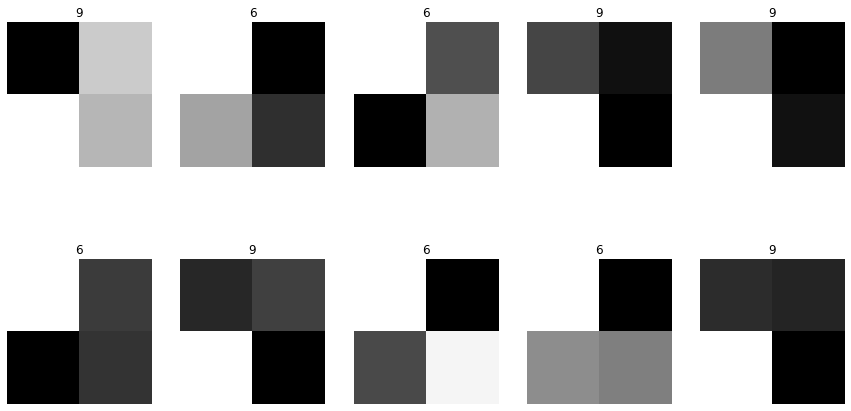

In [399]:
Helpers.plot_grid(data["PCA"]["6,9"]["x_train"],data["PCA"]["6,9"]["y_train"])

In [425]:
data["PCA"]["6,9"]["x_train"][1][0]

tensor(0.72161126, requires_grad=True)

In [426]:
y_pred = list()
for i in range(len(data["PCA"]["6,9"]["x_train"])):
    if data["PCA"]["6,9"]["x_train"][i][1] > 0.6:
        y_pred.append(6)
    else:
        y_pred.append(9)

In [427]:
np.where(np.array(y_pred) == data["PCA"]["6,9"]["y_train"])[0].size

5985

In [326]:
def fischer(x_train,y_train):
    classes =dict() 
    for classname in np.unique(y_train):
        classes[classname] = np.where(y_train == classname)[0]

    featureCount = x_train.shape[1]
    f = np.zeros(featureCount)
    for feature in range(featureCount):
        nenner = list()
        zaehler = list()
        for classname in classes:

            nc = len(classes[classname])
            x_class = x_train[classes[classname]]

            ufci = x_class[:,feature].mean()
            ufi = x_train[:,feature].mean()

            xli = x_class[:,feature]

            nenner.append(nc*(ufci-ufi)**2)
            zaehler.append(np.sum((xli-ufci)**2))

        f[feature] = np.sum(nenner)/np.sum(zaehler)
    return 1/(1+f)



In [368]:
l = list()
for preprocessing in data:
    for subset in data[preprocessing]:
        datasubset = data[preprocessing][subset]
        f = fischer(datasubset["x_train"],datasubset["y_train"])


        l.append({
            "preprocessing":preprocessing,
            "subset":subset,
            "fisher": f
        })


In [369]:
df = pd.DataFrame(l)
df["count"] = df["fisher"].apply(lambda x: np.where(x < 0.5)[0].shape[0])

In [329]:
df.groupby("preprocessing")["count"].mean()

preprocessing
Autoencoder_small    1.422222
PCA                  0.844444
Name: count, dtype: float64

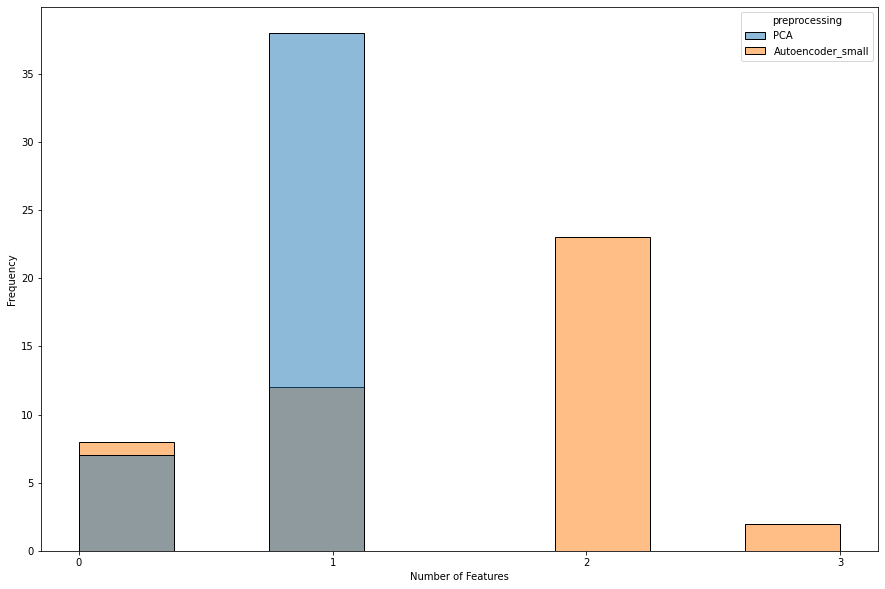

In [370]:
plt.figure(figsize=(15,10))
sns.histplot(data=df,hue="preprocessing",x="count")
plt.xlabel("Number of Features")
plt.ylabel("Frequency")
plt.xticks(np.arange(0,4,1))
plt.savefig("plots/histogram_fisher.png",dpi=300,bbox_inches="tight")
plt.show()

In [371]:
l = list()
for preprocessing in data:
    for subset in data[preprocessing]:
        importance = np.load("measure/featureimportance/{}/{}/importance.npy".format(preprocessing,subset))

        l.append({
            "preprocessing":preprocessing,
            "subset":subset,
            "importance": 1 / (1+importance.reshape(4,))
            "pixel": np.arange(1,4)
        })



In [377]:
df = pd.DataFrame(l)
df["argmax"] = df["importance"].apply(lambda x: np.argmin(x))
df.groupby("preprocessing")["argmax"].value_counts()

preprocessing      argmax
Autoencoder_small  1         23
                   2         11
                   0          6
                   3          5
PCA                0         39
                   1          3
                   3          2
                   2          1
Name: argmax, dtype: int64

In [363]:
df = pd.DataFrame(l)
df["count"] = df["importance"].apply(lambda x: np.where(x < 0.5)[0].shape[0])

In [365]:
df.groupby("preprocessing")["count"].mean()

preprocessing
Autoencoder_small    1.955556
PCA                  0.822222
Name: count, dtype: float64

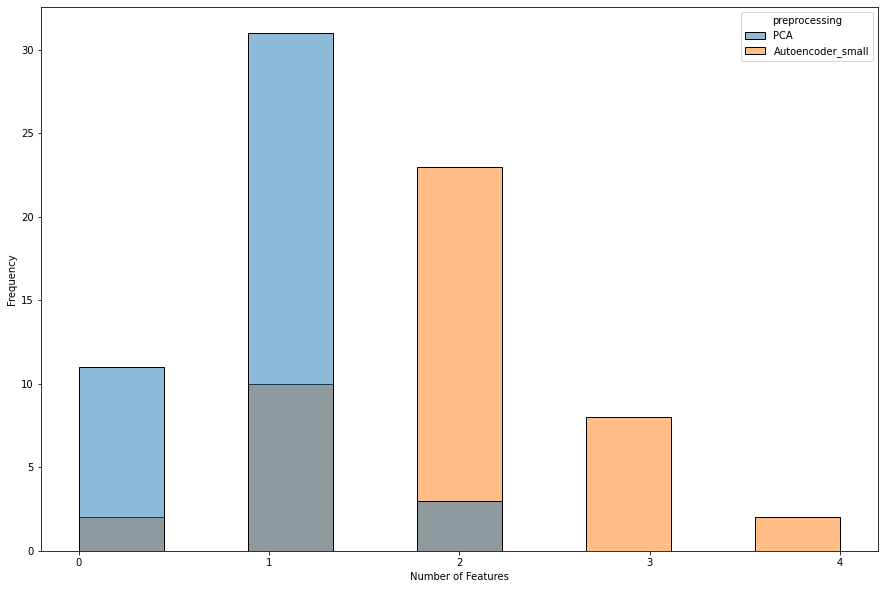

In [367]:
plt.figure(figsize=(15,10))
sns.histplot(data=df,hue="preprocessing",x="count")
plt.xlabel("Number of Features")
plt.ylabel("Frequency")
plt.xticks(np.arange(0,5,1))
plt.savefig("plots/histogram_importance.png",dpi=300,bbox_inches="tight")
plt.show()

# Check if perceptron yields similar results

In [55]:
def perceptron(x_train,y_train):
    tf.compat.v1.reset_default_graph()
    with tf.device("/gpu:0"):
        model = tf.keras.models.Sequential(
            [tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(x_train.shape[1],))])

        model.compile(optimizer='adam',loss="binary_crossentropy", metrics=['accuracy'])

        hist = model.fit(
                x=x_train,
                y=y_train,
                epochs=10,
                batch_size = 32,
                verbose=1).history
        
    return np.array([a.numpy() for a in model.trainable_weights])[0]

In [354]:
for preprocessing in data:
    for subset in data[preprocessing]:
        print(preprocessing,subset)
        datasubset = data[preprocessing][subset]
        w = perceptron(datasubset["x_train"],datasubset["y_train_binary"])

        mean = datasubset["x_train"].mean(axis=0).reshape(-1,1)


        Helpers.store((abs(w)*mean).numpy(),"measure/featureimportance/{}/{}".format(preprocessing,subset),"importance")


PCA 4,6
Epoch 1/10
 20/368 [>.............................] - ETA: 1s - loss: 0.8388 - accuracy: 0.5000

2022-02-15 17:38:28.886547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


368/368 [==============================] - 2s 5ms/step - loss: 0.7735 - accuracy: 0.4930
Epoch 2/10
368/368 [==============================] - 2s 4ms/step - loss: 0.7049 - accuracy: 0.4503
Epoch 3/10
368/368 [==============================] - 2s 5ms/step - loss: 0.6729 - accuracy: 0.6392
Epoch 4/10
368/368 [==============================] - 2s 5ms/step - loss: 0.6423 - accuracy: 0.7674
Epoch 5/10
368/368 [==============================] - 2s 5ms/step - loss: 0.6121 - accuracy: 0.8230
Epoch 6/10
368/368 [==============================] - 2s 4ms/step - loss: 0.5826 - accuracy: 0.8629
Epoch 7/10
368/368 [==============================] - 2s 4ms/step - loss: 0.5545 - accuracy: 0.8943
Epoch 8/10
368/368 [==============================] - 2s 4ms/step - loss: 0.5278 - accuracy: 0.9100
Epoch 9/10
368/368 [==============================] - 2s 5ms/step - loss: 0.5024 - accuracy: 0.9236
Epoch 10/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4785 - accuracy: 0.9371
PCA 4,8
Ep

/var/folders/09/d62qr57n6dl6znjwx73740hw0000gn/T/ipykernel_7170/624121198.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([a.numpy() for a in model.trainable_weights])[0]
2022-02-15 17:38:45.983404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


366/366 [==============================] - 2s 4ms/step - loss: 0.7285 - accuracy: 0.4037
Epoch 2/10
366/366 [==============================] - 2s 5ms/step - loss: 0.6972 - accuracy: 0.4861
Epoch 3/10
366/366 [==============================] - 2s 4ms/step - loss: 0.6697 - accuracy: 0.5853
Epoch 4/10
366/366 [==============================] - 2s 5ms/step - loss: 0.6432 - accuracy: 0.6835
Epoch 5/10
366/366 [==============================] - 2s 4ms/step - loss: 0.6179 - accuracy: 0.7639
Epoch 6/10
366/366 [==============================] - 2s 4ms/step - loss: 0.5940 - accuracy: 0.8296
Epoch 7/10
366/366 [==============================] - 2s 4ms/step - loss: 0.5713 - accuracy: 0.8610
Epoch 8/10
366/366 [==============================] - 2s 4ms/step - loss: 0.5498 - accuracy: 0.8871
Epoch 9/10
366/366 [==============================] - 2s 4ms/step - loss: 0.5294 - accuracy: 0.9018
Epoch 10/10
366/366 [==============================] - 2s 5ms/step - loss: 0.5102 - accuracy: 0.9130
PCA 0,7
Ep

2022-02-15 17:39:02.447261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - 2s 4ms/step - loss: 0.8221 - accuracy: 0.2403
Epoch 2/10
381/381 [==============================] - 2s 5ms/step - loss: 0.7723 - accuracy: 0.3200
Epoch 3/10
381/381 [==============================] - 2s 5ms/step - loss: 0.7261 - accuracy: 0.4397
Epoch 4/10
381/381 [==============================] - 2s 5ms/step - loss: 0.6824 - accuracy: 0.5736
Epoch 5/10
381/381 [==============================] - 2s 5ms/step - loss: 0.6413 - accuracy: 0.7009
Epoch 6/10
381/381 [==============================] - 2s 4ms/step - loss: 0.6029 - accuracy: 0.8174
Epoch 7/10
381/381 [==============================] - 2s 5ms/step - loss: 0.5670 - accuracy: 0.8860
Epoch 8/10
381/381 [==============================] - 2s 4ms/step - loss: 0.5335 - accuracy: 0.9252
Epoch 9/10
381/381 [==============================] - 2s 4ms/step - loss: 0.5022 - accuracy: 0.9458
Epoch 10/10
381/381 [==============================] - 2s 4ms/step - loss: 0.4730 - accuracy: 0.9581
PCA 2,3
Ep

2022-02-15 17:39:19.899495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


378/378 [==============================] - 2s 5ms/step - loss: 0.6624 - accuracy: 0.6300
Epoch 2/10
378/378 [==============================] - 2s 4ms/step - loss: 0.6306 - accuracy: 0.7357
Epoch 3/10
378/378 [==============================] - 2s 4ms/step - loss: 0.6011 - accuracy: 0.8070
Epoch 4/10
378/378 [==============================] - 2s 5ms/step - loss: 0.5740 - accuracy: 0.8484
Epoch 5/10
378/378 [==============================] - 2s 4ms/step - loss: 0.5490 - accuracy: 0.8728
Epoch 6/10
378/378 [==============================] - 2s 4ms/step - loss: 0.5257 - accuracy: 0.8906
Epoch 7/10
378/378 [==============================] - 2s 4ms/step - loss: 0.5040 - accuracy: 0.9010
Epoch 8/10
378/378 [==============================] - 2s 4ms/step - loss: 0.4837 - accuracy: 0.9076
Epoch 9/10
378/378 [==============================] - 2s 5ms/step - loss: 0.4649 - accuracy: 0.9135
Epoch 10/10
378/378 [==============================] - 2s 4ms/step - loss: 0.4474 - accuracy: 0.9169
PCA 0,9
Ep

2022-02-15 17:39:36.948051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


371/371 [==============================] - 2s 4ms/step - loss: 0.5965 - accuracy: 0.5770
Epoch 2/10
371/371 [==============================] - 1s 3ms/step - loss: 0.5301 - accuracy: 0.9415
Epoch 3/10
371/371 [==============================] - 1s 3ms/step - loss: 0.4902 - accuracy: 0.9661
Epoch 4/10
371/371 [==============================] - 1s 3ms/step - loss: 0.4576 - accuracy: 0.9673
Epoch 5/10
371/371 [==============================] - 1s 3ms/step - loss: 0.4290 - accuracy: 0.9679
Epoch 6/10
371/371 [==============================] - 1s 3ms/step - loss: 0.4034 - accuracy: 0.9690
Epoch 7/10
371/371 [==============================] - 1s 3ms/step - loss: 0.3800 - accuracy: 0.9683
Epoch 8/10
371/371 [==============================] - 1s 3ms/step - loss: 0.3587 - accuracy: 0.9691
Epoch 9/10
371/371 [==============================] - 1s 3ms/step - loss: 0.3392 - accuracy: 0.9706
Epoch 10/10
371/371 [==============================] - 1s 3ms/step - loss: 0.3212 - accuracy: 0.9708
PCA 2,4
Ep

2022-02-15 17:39:49.586567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 2s 5ms/step - loss: 0.7001 - accuracy: 0.5049
Epoch 2/10
369/369 [==============================] - 2s 4ms/step - loss: 0.6301 - accuracy: 0.6068
Epoch 3/10
369/369 [==============================] - 2s 4ms/step - loss: 0.5898 - accuracy: 0.8653
Epoch 4/10
369/369 [==============================] - 2s 4ms/step - loss: 0.5582 - accuracy: 0.9496
Epoch 5/10
369/369 [==============================] - 2s 4ms/step - loss: 0.5307 - accuracy: 0.9604
Epoch 6/10
369/369 [==============================] - 2s 4ms/step - loss: 0.5060 - accuracy: 0.9625
Epoch 7/10
369/369 [==============================] - 2s 5ms/step - loss: 0.4835 - accuracy: 0.9615
Epoch 8/10
369/369 [==============================] - 2s 5ms/step - loss: 0.4626 - accuracy: 0.9612
Epoch 9/10
369/369 [==============================] - 2s 4ms/step - loss: 0.4433 - accuracy: 0.9615
Epoch 10/10
369/369 [==============================] - 2s 4ms/step - loss: 0.4252 - accuracy: 0.9607
PCA 4,9
Ep

2022-02-15 17:40:06.245472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 2s 4ms/step - loss: 0.6807 - accuracy: 0.6145
Epoch 2/10
369/369 [==============================] - 2s 4ms/step - loss: 0.6669 - accuracy: 0.6678
Epoch 3/10
369/369 [==============================] - 2s 4ms/step - loss: 0.6549 - accuracy: 0.6817
Epoch 4/10
369/369 [==============================] - 2s 4ms/step - loss: 0.6443 - accuracy: 0.6887
Epoch 5/10
369/369 [==============================] - 2s 5ms/step - loss: 0.6347 - accuracy: 0.6926
Epoch 6/10
369/369 [==============================] - 2s 4ms/step - loss: 0.6261 - accuracy: 0.6964
Epoch 7/10
369/369 [==============================] - 2s 4ms/step - loss: 0.6185 - accuracy: 0.6993
Epoch 8/10
369/369 [==============================] - 2s 5ms/step - loss: 0.6118 - accuracy: 0.6991
Epoch 9/10
369/369 [==============================] - 2s 5ms/step - loss: 0.6058 - accuracy: 0.7005
Epoch 10/10
369/369 [==============================] - 2s 5ms/step - loss: 0.6004 - accuracy: 0.6996
PCA 4,7
Ep

2022-02-15 17:40:23.118631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - 2s 4ms/step - loss: 0.7196 - accuracy: 0.4336
Epoch 2/10
379/379 [==============================] - 2s 4ms/step - loss: 0.6779 - accuracy: 0.5756
Epoch 3/10
379/379 [==============================] - 2s 4ms/step - loss: 0.6415 - accuracy: 0.7233
Epoch 4/10
379/379 [==============================] - 2s 4ms/step - loss: 0.6078 - accuracy: 0.8365
Epoch 5/10
379/379 [==============================] - 2s 4ms/step - loss: 0.5766 - accuracy: 0.8995
Epoch 6/10
379/379 [==============================] - 2s 4ms/step - loss: 0.5474 - accuracy: 0.9257
Epoch 7/10
379/379 [==============================] - 2s 4ms/step - loss: 0.5203 - accuracy: 0.9409
Epoch 8/10
379/379 [==============================] - 2s 4ms/step - loss: 0.4950 - accuracy: 0.9504
Epoch 9/10
379/379 [==============================] - 2s 4ms/step - loss: 0.4713 - accuracy: 0.9551
Epoch 10/10
379/379 [==============================] - 2s 5ms/step - loss: 0.4492 - accuracy: 0.9602
PCA 0,8
Ep

2022-02-15 17:40:39.688613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


368/368 [==============================] - 2s 5ms/step - loss: 0.5981 - accuracy: 0.8219
Epoch 2/10
368/368 [==============================] - 2s 5ms/step - loss: 0.5595 - accuracy: 0.9422
Epoch 3/10
368/368 [==============================] - 2s 4ms/step - loss: 0.5278 - accuracy: 0.9493
Epoch 4/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4976 - accuracy: 0.9586
Epoch 5/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4693 - accuracy: 0.9608
Epoch 6/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4429 - accuracy: 0.9625
Epoch 7/10
368/368 [==============================] - 2s 5ms/step - loss: 0.4184 - accuracy: 0.9649
Epoch 8/10
368/368 [==============================] - 2s 4ms/step - loss: 0.3956 - accuracy: 0.9665
Epoch 9/10
368/368 [==============================] - 2s 4ms/step - loss: 0.3744 - accuracy: 0.9674
Epoch 10/10
368/368 [==============================] - 2s 4ms/step - loss: 0.3547 - accuracy: 0.9678
PCA 2,5
Ep

2022-02-15 17:40:56.432325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


356/356 [==============================] - 2s 5ms/step - loss: 0.6530 - accuracy: 0.5934
Epoch 2/10
356/356 [==============================] - 2s 4ms/step - loss: 0.6085 - accuracy: 0.8160
Epoch 3/10
356/356 [==============================] - 2s 4ms/step - loss: 0.5888 - accuracy: 0.8191
Epoch 4/10
356/356 [==============================] - 2s 4ms/step - loss: 0.5694 - accuracy: 0.8351
Epoch 5/10
356/356 [==============================] - 2s 5ms/step - loss: 0.5500 - accuracy: 0.8488
Epoch 6/10
356/356 [==============================] - 2s 4ms/step - loss: 0.5310 - accuracy: 0.8605
Epoch 7/10
356/356 [==============================] - 2s 4ms/step - loss: 0.5128 - accuracy: 0.8699
Epoch 8/10
356/356 [==============================] - 2s 4ms/step - loss: 0.4954 - accuracy: 0.8773
Epoch 9/10
356/356 [==============================] - 2s 4ms/step - loss: 0.4788 - accuracy: 0.8807
Epoch 10/10
356/356 [==============================] - 2s 5ms/step - loss: 0.4630 - accuracy: 0.8862
PCA 0,6
Ep

2022-02-15 17:41:12.598882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


371/371 [==============================] - 2s 5ms/step - loss: 0.7116 - accuracy: 0.5277
Epoch 2/10
371/371 [==============================] - 2s 5ms/step - loss: 0.6661 - accuracy: 0.6428
Epoch 3/10
371/371 [==============================] - 2s 5ms/step - loss: 0.6341 - accuracy: 0.7627
Epoch 4/10
371/371 [==============================] - 2s 4ms/step - loss: 0.6032 - accuracy: 0.8357
Epoch 5/10
371/371 [==============================] - 2s 4ms/step - loss: 0.5735 - accuracy: 0.8846
Epoch 6/10
371/371 [==============================] - 2s 4ms/step - loss: 0.5453 - accuracy: 0.9116
Epoch 7/10
371/371 [==============================] - 2s 5ms/step - loss: 0.5188 - accuracy: 0.9264
Epoch 8/10
371/371 [==============================] - 2s 4ms/step - loss: 0.4937 - accuracy: 0.9343
Epoch 9/10
371/371 [==============================] - 2s 5ms/step - loss: 0.4703 - accuracy: 0.9387
Epoch 10/10
371/371 [==============================] - 2s 5ms/step - loss: 0.4483 - accuracy: 0.9435
PCA 0,1
Ep

2022-02-15 17:41:29.760535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


396/396 [==============================] - 2s 5ms/step - loss: 0.8897 - accuracy: 0.5242
Epoch 2/10
396/396 [==============================] - 2s 4ms/step - loss: 0.7770 - accuracy: 0.3286
Epoch 3/10
396/396 [==============================] - 2s 4ms/step - loss: 0.7257 - accuracy: 0.3565
Epoch 4/10
396/396 [==============================] - 2s 4ms/step - loss: 0.6816 - accuracy: 0.5057
Epoch 5/10
396/396 [==============================] - 2s 4ms/step - loss: 0.6386 - accuracy: 0.6835
Epoch 6/10
396/396 [==============================] - 2s 4ms/step - loss: 0.5974 - accuracy: 0.8253
Epoch 7/10
396/396 [==============================] - 2s 4ms/step - loss: 0.5584 - accuracy: 0.9278
Epoch 8/10
396/396 [==============================] - 2s 4ms/step - loss: 0.5217 - accuracy: 0.9679
Epoch 9/10
396/396 [==============================] - 2s 5ms/step - loss: 0.4874 - accuracy: 0.9787
Epoch 10/10
396/396 [==============================] - 2s 4ms/step - loss: 0.4554 - accuracy: 0.9844
PCA 3,7
Ep

2022-02-15 17:41:47.450170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


388/388 [==============================] - 2s 5ms/step - loss: 0.7118 - accuracy: 0.5659
Epoch 2/10
388/388 [==============================] - 2s 4ms/step - loss: 0.6692 - accuracy: 0.6676
Epoch 3/10
388/388 [==============================] - 2s 5ms/step - loss: 0.6314 - accuracy: 0.7442
Epoch 4/10
388/388 [==============================] - 2s 4ms/step - loss: 0.5969 - accuracy: 0.8077
Epoch 5/10
388/388 [==============================] - 2s 4ms/step - loss: 0.5652 - accuracy: 0.8554
Epoch 6/10
388/388 [==============================] - 2s 4ms/step - loss: 0.5357 - accuracy: 0.8928
Epoch 7/10
388/388 [==============================] - 2s 4ms/step - loss: 0.5085 - accuracy: 0.9209
Epoch 8/10
388/388 [==============================] - 2s 5ms/step - loss: 0.4831 - accuracy: 0.9364
Epoch 9/10
388/388 [==============================] - 2s 4ms/step - loss: 0.4595 - accuracy: 0.9447
Epoch 10/10
388/388 [==============================] - 2s 4ms/step - loss: 0.4377 - accuracy: 0.9494
PCA 1,3
Ep

2022-02-15 17:42:04.909756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


403/403 [==============================] - 2s 5ms/step - loss: 0.6948 - accuracy: 0.5249
Epoch 2/10
403/403 [==============================] - 2s 5ms/step - loss: 0.6487 - accuracy: 0.6600
Epoch 3/10
403/403 [==============================] - 2s 4ms/step - loss: 0.6077 - accuracy: 0.8568
Epoch 4/10
403/403 [==============================] - 2s 4ms/step - loss: 0.5705 - accuracy: 0.9138
Epoch 5/10
403/403 [==============================] - 2s 4ms/step - loss: 0.5363 - accuracy: 0.9267
Epoch 6/10
403/403 [==============================] - 2s 4ms/step - loss: 0.5050 - accuracy: 0.9414
Epoch 7/10
403/403 [==============================] - 2s 5ms/step - loss: 0.4761 - accuracy: 0.9470
Epoch 8/10
403/403 [==============================] - 2s 5ms/step - loss: 0.4495 - accuracy: 0.9502
Epoch 9/10
403/403 [==============================] - 2s 4ms/step - loss: 0.4250 - accuracy: 0.9539
Epoch 10/10
403/403 [==============================] - 2s 4ms/step - loss: 0.4022 - accuracy: 0.9566
PCA 1,4
Ep

2022-02-15 17:42:23.184658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


394/394 [==============================] - 2s 4ms/step - loss: 0.6732 - accuracy: 0.6337
Epoch 2/10
394/394 [==============================] - 2s 4ms/step - loss: 0.6094 - accuracy: 0.8460
Epoch 3/10
394/394 [==============================] - 2s 4ms/step - loss: 0.5671 - accuracy: 0.9123
Epoch 4/10
394/394 [==============================] - 2s 5ms/step - loss: 0.5311 - accuracy: 0.9537
Epoch 5/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4989 - accuracy: 0.9681
Epoch 6/10
394/394 [==============================] - 2s 4ms/step - loss: 0.4697 - accuracy: 0.9743
Epoch 7/10
394/394 [==============================] - 2s 4ms/step - loss: 0.4430 - accuracy: 0.9770
Epoch 8/10
394/394 [==============================] - 2s 4ms/step - loss: 0.4184 - accuracy: 0.9771
Epoch 9/10
394/394 [==============================] - 2s 4ms/step - loss: 0.3957 - accuracy: 0.9777
Epoch 10/10
394/394 [==============================] - 2s 4ms/step - loss: 0.3747 - accuracy: 0.9781
PCA 3,9
Ep

2022-02-15 17:42:40.747223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


378/378 [==============================] - 2s 5ms/step - loss: 0.6624 - accuracy: 0.5594
Epoch 2/10
378/378 [==============================] - 2s 4ms/step - loss: 0.6215 - accuracy: 0.7202
Epoch 3/10
378/378 [==============================] - 2s 4ms/step - loss: 0.5886 - accuracy: 0.8090
Epoch 4/10
378/378 [==============================] - 2s 4ms/step - loss: 0.5590 - accuracy: 0.8546
Epoch 5/10
378/378 [==============================] - 2s 4ms/step - loss: 0.5319 - accuracy: 0.8874
Epoch 6/10
378/378 [==============================] - 2s 4ms/step - loss: 0.5071 - accuracy: 0.9051
Epoch 7/10
378/378 [==============================] - 2s 4ms/step - loss: 0.4840 - accuracy: 0.9172
Epoch 8/10
378/378 [==============================] - 2s 5ms/step - loss: 0.4627 - accuracy: 0.9275
Epoch 9/10
378/378 [==============================] - 2s 5ms/step - loss: 0.4429 - accuracy: 0.9325
Epoch 10/10
378/378 [==============================] - 2s 4ms/step - loss: 0.4245 - accuracy: 0.9356
PCA 7,8
Ep

2022-02-15 17:42:58.003937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - 2s 5ms/step - loss: 0.7034 - accuracy: 0.4818
Epoch 2/10
379/379 [==============================] - 2s 4ms/step - loss: 0.6653 - accuracy: 0.6250
Epoch 3/10
379/379 [==============================] - 2s 4ms/step - loss: 0.6297 - accuracy: 0.7536
Epoch 4/10
379/379 [==============================] - 2s 4ms/step - loss: 0.5966 - accuracy: 0.8448
Epoch 5/10
379/379 [==============================] - 2s 5ms/step - loss: 0.5658 - accuracy: 0.8905
Epoch 6/10
379/379 [==============================] - 2s 4ms/step - loss: 0.5371 - accuracy: 0.9165
Epoch 7/10
379/379 [==============================] - 2s 5ms/step - loss: 0.5105 - accuracy: 0.9265
Epoch 8/10
379/379 [==============================] - 2s 5ms/step - loss: 0.4857 - accuracy: 0.9335
Epoch 9/10
379/379 [==============================] - 2s 4ms/step - loss: 0.4625 - accuracy: 0.9382
Epoch 10/10
379/379 [==============================] - 2s 5ms/step - loss: 0.4409 - accuracy: 0.9410
PCA 1,5
Ep

2022-02-15 17:43:15.301680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - 2s 5ms/step - loss: 0.8078 - accuracy: 0.4322
Epoch 2/10
381/381 [==============================] - 2s 5ms/step - loss: 0.7608 - accuracy: 0.3258
Epoch 3/10
381/381 [==============================] - 2s 4ms/step - loss: 0.7217 - accuracy: 0.4482
Epoch 4/10
381/381 [==============================] - 2s 5ms/step - loss: 0.6846 - accuracy: 0.5543
Epoch 5/10
381/381 [==============================] - 2s 5ms/step - loss: 0.6492 - accuracy: 0.6472
Epoch 6/10
381/381 [==============================] - 2s 4ms/step - loss: 0.6162 - accuracy: 0.8742
Epoch 7/10
381/381 [==============================] - 2s 4ms/step - loss: 0.5850 - accuracy: 0.8930
Epoch 8/10
381/381 [==============================] - 2s 4ms/step - loss: 0.5559 - accuracy: 0.9147
Epoch 9/10
381/381 [==============================] - 2s 5ms/step - loss: 0.5287 - accuracy: 0.9269
Epoch 10/10
381/381 [==============================] - 2s 4ms/step - loss: 0.5032 - accuracy: 0.9299
PCA 3,8
Ep

2022-02-15 17:43:32.632139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 2s 5ms/step - loss: 0.6252 - accuracy: 0.6698
Epoch 2/10
375/375 [==============================] - 2s 5ms/step - loss: 0.5977 - accuracy: 0.7757
Epoch 3/10
375/375 [==============================] - 2s 5ms/step - loss: 0.5775 - accuracy: 0.8082
Epoch 4/10
375/375 [==============================] - 2s 5ms/step - loss: 0.5584 - accuracy: 0.8279
Epoch 5/10
375/375 [==============================] - 2s 4ms/step - loss: 0.5404 - accuracy: 0.8405
Epoch 6/10
375/375 [==============================] - 2s 4ms/step - loss: 0.5239 - accuracy: 0.8479
Epoch 7/10
375/375 [==============================] - 2s 4ms/step - loss: 0.5086 - accuracy: 0.8538
Epoch 8/10
375/375 [==============================] - 2s 4ms/step - loss: 0.4946 - accuracy: 0.8560
Epoch 9/10
375/375 [==============================] - 2s 4ms/step - loss: 0.4817 - accuracy: 0.8587
Epoch 10/10
375/375 [==============================] - 2s 4ms/step - loss: 0.4699 - accuracy: 0.8600
PCA 1,2
Ep

2022-02-15 17:43:49.734639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


397/397 [==============================] - 2s 5ms/step - loss: 0.6278 - accuracy: 0.6413
Epoch 2/10
397/397 [==============================] - 2s 5ms/step - loss: 0.5693 - accuracy: 0.9070
Epoch 3/10
397/397 [==============================] - 2s 5ms/step - loss: 0.5331 - accuracy: 0.9217
Epoch 4/10
397/397 [==============================] - 2s 4ms/step - loss: 0.5025 - accuracy: 0.9303
Epoch 5/10
397/397 [==============================] - 2s 5ms/step - loss: 0.4753 - accuracy: 0.9328
Epoch 6/10
397/397 [==============================] - 2s 5ms/step - loss: 0.4507 - accuracy: 0.9351
Epoch 7/10
397/397 [==============================] - 2s 5ms/step - loss: 0.4284 - accuracy: 0.9380
Epoch 8/10
397/397 [==============================] - 2s 4ms/step - loss: 0.4079 - accuracy: 0.9391
Epoch 9/10
397/397 [==============================] - 2s 4ms/step - loss: 0.3890 - accuracy: 0.9394
Epoch 10/10
397/397 [==============================] - 2s 4ms/step - loss: 0.3714 - accuracy: 0.9426
PCA 3,6
Ep

2022-02-15 17:44:08.446087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


377/377 [==============================] - 2s 4ms/step - loss: 0.6151 - accuracy: 0.5483
Epoch 2/10
377/377 [==============================] - 2s 4ms/step - loss: 0.5493 - accuracy: 0.8694
Epoch 3/10
377/377 [==============================] - 1s 4ms/step - loss: 0.5108 - accuracy: 0.9421
Epoch 4/10
377/377 [==============================] - 2s 4ms/step - loss: 0.4804 - accuracy: 0.9597
Epoch 5/10
377/377 [==============================] - 2s 4ms/step - loss: 0.4541 - accuracy: 0.9620
Epoch 6/10
377/377 [==============================] - 2s 4ms/step - loss: 0.4307 - accuracy: 0.9632
Epoch 7/10
377/377 [==============================] - 2s 4ms/step - loss: 0.4095 - accuracy: 0.9655
Epoch 8/10
377/377 [==============================] - 2s 4ms/step - loss: 0.3900 - accuracy: 0.9649
Epoch 9/10
377/377 [==============================] - 2s 4ms/step - loss: 0.3722 - accuracy: 0.9656
Epoch 10/10
377/377 [==============================] - 2s 4ms/step - loss: 0.3556 - accuracy: 0.9666
PCA 7,9
Ep

2022-02-15 17:44:24.528798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 2s 4ms/step - loss: 0.6270 - accuracy: 0.7089
Epoch 2/10
382/382 [==============================] - 2s 4ms/step - loss: 0.5970 - accuracy: 0.8303
Epoch 3/10
382/382 [==============================] - 2s 4ms/step - loss: 0.5720 - accuracy: 0.8511
Epoch 4/10
382/382 [==============================] - 2s 4ms/step - loss: 0.5492 - accuracy: 0.8637
Epoch 5/10
382/382 [==============================] - 2s 4ms/step - loss: 0.5284 - accuracy: 0.8715
Epoch 6/10
382/382 [==============================] - 2s 4ms/step - loss: 0.5092 - accuracy: 0.8759
Epoch 7/10
382/382 [==============================] - 2s 4ms/step - loss: 0.4915 - accuracy: 0.8806
Epoch 8/10
382/382 [==============================] - 2s 4ms/step - loss: 0.4752 - accuracy: 0.8857
Epoch 9/10
382/382 [==============================] - 2s 4ms/step - loss: 0.4601 - accuracy: 0.8876
Epoch 10/10
382/382 [==============================] - 2s 4ms/step - loss: 0.4462 - accuracy: 0.8883
PCA 2,9
Ep

2022-02-15 17:44:41.012455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


373/373 [==============================] - 2s 5ms/step - loss: 0.7198 - accuracy: 0.5081
Epoch 2/10
373/373 [==============================] - 2s 5ms/step - loss: 0.6717 - accuracy: 0.5829
Epoch 3/10
373/373 [==============================] - 2s 4ms/step - loss: 0.6440 - accuracy: 0.7007
Epoch 4/10
373/373 [==============================] - 2s 4ms/step - loss: 0.6165 - accuracy: 0.7876
Epoch 5/10
373/373 [==============================] - 2s 4ms/step - loss: 0.5897 - accuracy: 0.8523
Epoch 6/10
373/373 [==============================] - 2s 4ms/step - loss: 0.5639 - accuracy: 0.8974
Epoch 7/10
373/373 [==============================] - 2s 4ms/step - loss: 0.5392 - accuracy: 0.9223
Epoch 8/10
373/373 [==============================] - 2s 4ms/step - loss: 0.5158 - accuracy: 0.9337
Epoch 9/10
373/373 [==============================] - 2s 4ms/step - loss: 0.4935 - accuracy: 0.9456
Epoch 10/10
373/373 [==============================] - 2s 5ms/step - loss: 0.4725 - accuracy: 0.9494
PCA 0,4
Ep

2022-02-15 17:44:57.540287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


368/368 [==============================] - 2s 5ms/step - loss: 0.5815 - accuracy: 0.8707
Epoch 2/10
368/368 [==============================] - 2s 4ms/step - loss: 0.5442 - accuracy: 0.9249
Epoch 3/10
368/368 [==============================] - 2s 4ms/step - loss: 0.5098 - accuracy: 0.9482
Epoch 4/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4782 - accuracy: 0.9622
Epoch 5/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4491 - accuracy: 0.9663
Epoch 6/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4223 - accuracy: 0.9742
Epoch 7/10
368/368 [==============================] - 2s 4ms/step - loss: 0.3975 - accuracy: 0.9760
Epoch 8/10
368/368 [==============================] - 2s 5ms/step - loss: 0.3746 - accuracy: 0.9780
Epoch 9/10
368/368 [==============================] - 2s 4ms/step - loss: 0.3535 - accuracy: 0.9794
Epoch 10/10
368/368 [==============================] - 2s 4ms/step - loss: 0.3338 - accuracy: 0.9809
PCA 0,3
Ep

2022-02-15 17:45:14.273401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


377/377 [==============================] - 2s 4ms/step - loss: 0.6478 - accuracy: 0.4974
Epoch 2/10
377/377 [==============================] - 2s 4ms/step - loss: 0.5756 - accuracy: 0.7778
Epoch 3/10
377/377 [==============================] - 2s 4ms/step - loss: 0.5358 - accuracy: 0.9081
Epoch 4/10
377/377 [==============================] - 2s 4ms/step - loss: 0.5050 - accuracy: 0.9265
Epoch 5/10
377/377 [==============================] - 2s 4ms/step - loss: 0.4786 - accuracy: 0.9336
Epoch 6/10
377/377 [==============================] - 2s 4ms/step - loss: 0.4547 - accuracy: 0.9374
Epoch 7/10
377/377 [==============================] - 2s 4ms/step - loss: 0.4330 - accuracy: 0.9399
Epoch 8/10
377/377 [==============================] - 2s 4ms/step - loss: 0.4132 - accuracy: 0.9437
Epoch 9/10
377/377 [==============================] - 2s 5ms/step - loss: 0.3948 - accuracy: 0.9460
Epoch 10/10
377/377 [==============================] - 2s 5ms/step - loss: 0.3779 - accuracy: 0.9472
PCA 2,7
Ep

2022-02-15 17:45:31.183845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 2s 5ms/step - loss: 0.6626 - accuracy: 0.6811
Epoch 2/10
382/382 [==============================] - 2s 5ms/step - loss: 0.6285 - accuracy: 0.8098
Epoch 3/10
382/382 [==============================] - 2s 4ms/step - loss: 0.5969 - accuracy: 0.8697
Epoch 4/10
382/382 [==============================] - 2s 5ms/step - loss: 0.5671 - accuracy: 0.9037
Epoch 5/10
382/382 [==============================] - 2s 5ms/step - loss: 0.5394 - accuracy: 0.9161
Epoch 6/10
382/382 [==============================] - 2s 5ms/step - loss: 0.5135 - accuracy: 0.9275
Epoch 7/10
382/382 [==============================] - 2s 5ms/step - loss: 0.4893 - accuracy: 0.9322
Epoch 8/10
382/382 [==============================] - 2s 5ms/step - loss: 0.4665 - accuracy: 0.9379
Epoch 9/10
382/382 [==============================] - 2s 4ms/step - loss: 0.4454 - accuracy: 0.9387
Epoch 10/10
382/382 [==============================] - 2s 5ms/step - loss: 0.4255 - accuracy: 0.9413
PCA 8,9
Ep

2022-02-15 17:45:49.418000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 2s 5ms/step - loss: 0.7823 - accuracy: 0.5036
Epoch 2/10
369/369 [==============================] - 2s 4ms/step - loss: 0.7213 - accuracy: 0.2775
Epoch 3/10
369/369 [==============================] - 2s 4ms/step - loss: 0.6952 - accuracy: 0.4865
Epoch 4/10
369/369 [==============================] - 2s 4ms/step - loss: 0.6701 - accuracy: 0.5868
Epoch 5/10
369/369 [==============================] - 2s 4ms/step - loss: 0.6449 - accuracy: 0.7156
Epoch 6/10
369/369 [==============================] - 2s 5ms/step - loss: 0.6199 - accuracy: 0.8217
Epoch 7/10
369/369 [==============================] - 2s 5ms/step - loss: 0.5958 - accuracy: 0.8499
Epoch 8/10
369/369 [==============================] - 2s 5ms/step - loss: 0.5727 - accuracy: 0.8739
Epoch 9/10
369/369 [==============================] - 2s 5ms/step - loss: 0.5506 - accuracy: 0.8856
Epoch 10/10
369/369 [==============================] - 2s 4ms/step - loss: 0.5298 - accuracy: 0.8966
PCA 4,5
Ep

2022-02-15 17:46:06.187322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


352/352 [==============================] - 2s 5ms/step - loss: 0.6289 - accuracy: 0.6489
Epoch 2/10
352/352 [==============================] - 2s 5ms/step - loss: 0.5925 - accuracy: 0.8023
Epoch 3/10
352/352 [==============================] - 2s 5ms/step - loss: 0.5658 - accuracy: 0.8528
Epoch 4/10
352/352 [==============================] - 2s 4ms/step - loss: 0.5422 - accuracy: 0.8773
Epoch 5/10
352/352 [==============================] - 2s 4ms/step - loss: 0.5207 - accuracy: 0.8947
Epoch 6/10
352/352 [==============================] - 2s 5ms/step - loss: 0.5009 - accuracy: 0.9035
Epoch 7/10
352/352 [==============================] - 2s 4ms/step - loss: 0.4825 - accuracy: 0.9109
Epoch 8/10
352/352 [==============================] - 1s 4ms/step - loss: 0.4655 - accuracy: 0.9154
Epoch 9/10
352/352 [==============================] - 2s 4ms/step - loss: 0.4496 - accuracy: 0.9179
Epoch 10/10
352/352 [==============================] - 2s 4ms/step - loss: 0.4346 - accuracy: 0.9200
PCA 6,8
Ep

2022-02-15 17:46:22.090643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


368/368 [==============================] - 2s 5ms/step - loss: 0.6315 - accuracy: 0.7312
Epoch 2/10
368/368 [==============================] - 2s 4ms/step - loss: 0.5986 - accuracy: 0.8115
Epoch 3/10
368/368 [==============================] - 2s 5ms/step - loss: 0.5684 - accuracy: 0.8642
Epoch 4/10
368/368 [==============================] - 2s 5ms/step - loss: 0.5407 - accuracy: 0.9040
Epoch 5/10
368/368 [==============================] - 2s 4ms/step - loss: 0.5149 - accuracy: 0.9218
Epoch 6/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4908 - accuracy: 0.9357
Epoch 7/10
368/368 [==============================] - 2s 5ms/step - loss: 0.4683 - accuracy: 0.9447
Epoch 8/10
368/368 [==============================] - 2s 5ms/step - loss: 0.4473 - accuracy: 0.9492
Epoch 9/10
368/368 [==============================] - 2s 5ms/step - loss: 0.4277 - accuracy: 0.9521
Epoch 10/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4092 - accuracy: 0.9557
PCA 2,6
Ep

2022-02-15 17:46:39.017756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


372/372 [==============================] - 2s 5ms/step - loss: 0.7366 - accuracy: 0.2449
Epoch 2/10
372/372 [==============================] - 2s 5ms/step - loss: 0.7068 - accuracy: 0.4953
Epoch 3/10
372/372 [==============================] - 2s 5ms/step - loss: 0.6790 - accuracy: 0.6582
Epoch 4/10
372/372 [==============================] - 2s 4ms/step - loss: 0.6524 - accuracy: 0.7439
Epoch 5/10
372/372 [==============================] - 2s 5ms/step - loss: 0.6271 - accuracy: 0.7996
Epoch 6/10
372/372 [==============================] - 2s 5ms/step - loss: 0.6033 - accuracy: 0.8350
Epoch 7/10
372/372 [==============================] - 2s 5ms/step - loss: 0.5807 - accuracy: 0.8591
Epoch 8/10
372/372 [==============================] - 2s 4ms/step - loss: 0.5594 - accuracy: 0.8734
Epoch 9/10
372/372 [==============================] - 2s 4ms/step - loss: 0.5392 - accuracy: 0.8847
Epoch 10/10
372/372 [==============================] - 2s 4ms/step - loss: 0.5202 - accuracy: 0.8907
PCA 0,2
Ep

2022-02-15 17:46:55.804379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


372/372 [==============================] - 2s 4ms/step - loss: 0.6589 - accuracy: 0.6141
Epoch 2/10
372/372 [==============================] - 2s 4ms/step - loss: 0.6189 - accuracy: 0.7461
Epoch 3/10
372/372 [==============================] - 2s 5ms/step - loss: 0.5832 - accuracy: 0.8378
Epoch 4/10
372/372 [==============================] - 2s 4ms/step - loss: 0.5505 - accuracy: 0.8990
Epoch 5/10
372/372 [==============================] - 2s 4ms/step - loss: 0.5205 - accuracy: 0.9304
Epoch 6/10
372/372 [==============================] - 2s 4ms/step - loss: 0.4930 - accuracy: 0.9455
Epoch 7/10
372/372 [==============================] - 2s 4ms/step - loss: 0.4676 - accuracy: 0.9533
Epoch 8/10
372/372 [==============================] - 2s 4ms/step - loss: 0.4442 - accuracy: 0.9583
Epoch 9/10
372/372 [==============================] - 2s 4ms/step - loss: 0.4225 - accuracy: 0.9608
Epoch 10/10
372/372 [==============================] - 2s 5ms/step - loss: 0.4023 - accuracy: 0.9624
PCA 2,8
Ep

2022-02-15 17:47:12.537586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


370/370 [==============================] - 2s 5ms/step - loss: 0.8435 - accuracy: 0.4955
Epoch 2/10
370/370 [==============================] - 2s 4ms/step - loss: 0.7439 - accuracy: 0.4292
Epoch 3/10
370/370 [==============================] - 2s 4ms/step - loss: 0.7146 - accuracy: 0.3786
Epoch 4/10
370/370 [==============================] - 2s 4ms/step - loss: 0.6921 - accuracy: 0.4944
Epoch 5/10
370/370 [==============================] - 2s 4ms/step - loss: 0.6692 - accuracy: 0.6395
Epoch 6/10
370/370 [==============================] - 2s 4ms/step - loss: 0.6463 - accuracy: 0.7444
Epoch 7/10
370/370 [==============================] - 2s 5ms/step - loss: 0.6237 - accuracy: 0.8054
Epoch 8/10
370/370 [==============================] - 2s 4ms/step - loss: 0.6016 - accuracy: 0.8383
Epoch 9/10
370/370 [==============================] - 2s 4ms/step - loss: 0.5804 - accuracy: 0.8641
Epoch 10/10
370/370 [==============================] - 2s 4ms/step - loss: 0.5600 - accuracy: 0.8782
PCA 0,5
Ep

2022-02-15 17:47:29.149057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


355/355 [==============================] - 2s 5ms/step - loss: 0.6406 - accuracy: 0.6797
Epoch 2/10
355/355 [==============================] - 2s 5ms/step - loss: 0.6154 - accuracy: 0.7056
Epoch 3/10
355/355 [==============================] - 2s 4ms/step - loss: 0.5961 - accuracy: 0.7236
Epoch 4/10
355/355 [==============================] - 2s 5ms/step - loss: 0.5774 - accuracy: 0.7603
Epoch 5/10
355/355 [==============================] - 2s 5ms/step - loss: 0.5595 - accuracy: 0.7874
Epoch 6/10
355/355 [==============================] - 2s 5ms/step - loss: 0.5424 - accuracy: 0.8087
Epoch 7/10
355/355 [==============================] - 2s 4ms/step - loss: 0.5264 - accuracy: 0.8216
Epoch 8/10
355/355 [==============================] - 2s 4ms/step - loss: 0.5111 - accuracy: 0.8337
Epoch 9/10
355/355 [==============================] - 2s 4ms/step - loss: 0.4967 - accuracy: 0.8473
Epoch 10/10
355/355 [==============================] - 2s 5ms/step - loss: 0.4831 - accuracy: 0.8535
PCA 6,7
Ep

2022-02-15 17:47:45.583314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - 2s 5ms/step - loss: 0.5939 - accuracy: 0.6868
Epoch 2/10
381/381 [==============================] - 2s 5ms/step - loss: 0.5308 - accuracy: 0.8514
Epoch 3/10
381/381 [==============================] - 2s 4ms/step - loss: 0.4914 - accuracy: 0.9091
Epoch 4/10
381/381 [==============================] - 2s 4ms/step - loss: 0.4593 - accuracy: 0.9342
Epoch 5/10
381/381 [==============================] - 2s 4ms/step - loss: 0.4311 - accuracy: 0.9489
Epoch 6/10
381/381 [==============================] - 2s 4ms/step - loss: 0.4058 - accuracy: 0.9574
Epoch 7/10
381/381 [==============================] - 2s 4ms/step - loss: 0.3829 - accuracy: 0.9643
Epoch 8/10
381/381 [==============================] - 2s 4ms/step - loss: 0.3620 - accuracy: 0.9679
Epoch 9/10
381/381 [==============================] - 2s 5ms/step - loss: 0.3427 - accuracy: 0.9710
Epoch 10/10
381/381 [==============================] - 2s 4ms/step - loss: 0.3249 - accuracy: 0.9732
PCA 6,9
Ep

2022-02-15 17:48:02.610369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


371/371 [==============================] - 2s 5ms/step - loss: 0.7015 - accuracy: 0.4627
Epoch 2/10
371/371 [==============================] - 2s 4ms/step - loss: 0.6612 - accuracy: 0.6187
Epoch 3/10
371/371 [==============================] - 2s 4ms/step - loss: 0.6234 - accuracy: 0.7472
Epoch 4/10
371/371 [==============================] - 2s 5ms/step - loss: 0.5876 - accuracy: 0.8309
Epoch 5/10
371/371 [==============================] - 2s 4ms/step - loss: 0.5541 - accuracy: 0.8790
Epoch 6/10
371/371 [==============================] - 2s 5ms/step - loss: 0.5227 - accuracy: 0.9143
Epoch 7/10
371/371 [==============================] - 2s 5ms/step - loss: 0.4934 - accuracy: 0.9392
Epoch 8/10
371/371 [==============================] - 2s 5ms/step - loss: 0.4662 - accuracy: 0.9510
Epoch 9/10
371/371 [==============================] - 2s 5ms/step - loss: 0.4407 - accuracy: 0.9639
Epoch 10/10
371/371 [==============================] - 2s 4ms/step - loss: 0.4168 - accuracy: 0.9707
PCA 5,8
Ep

2022-02-15 17:48:19.845538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


353/353 [==============================] - 2s 5ms/step - loss: 0.7743 - accuracy: 0.1708
Epoch 2/10
353/353 [==============================] - 2s 5ms/step - loss: 0.7418 - accuracy: 0.2125
Epoch 3/10
353/353 [==============================] - 2s 4ms/step - loss: 0.7110 - accuracy: 0.3681
Epoch 4/10
353/353 [==============================] - 2s 5ms/step - loss: 0.6821 - accuracy: 0.6225
Epoch 5/10
353/353 [==============================] - 2s 5ms/step - loss: 0.6548 - accuracy: 0.7873
Epoch 6/10
353/353 [==============================] - 2s 4ms/step - loss: 0.6289 - accuracy: 0.8599
Epoch 7/10
353/353 [==============================] - 2s 5ms/step - loss: 0.6046 - accuracy: 0.8956
Epoch 8/10
353/353 [==============================] - 2s 4ms/step - loss: 0.5820 - accuracy: 0.9047
Epoch 9/10
353/353 [==============================] - 2s 4ms/step - loss: 0.5606 - accuracy: 0.9118
Epoch 10/10
353/353 [==============================] - 2s 5ms/step - loss: 0.5407 - accuracy: 0.9156
PCA 5,6
Ep

2022-02-15 17:48:36.082465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


355/355 [==============================] - 2s 5ms/step - loss: 0.7125 - accuracy: 0.5482
Epoch 2/10
355/355 [==============================] - 2s 5ms/step - loss: 0.6776 - accuracy: 0.6260
Epoch 3/10
355/355 [==============================] - 2s 4ms/step - loss: 0.6464 - accuracy: 0.6987
Epoch 4/10
355/355 [==============================] - 2s 4ms/step - loss: 0.6176 - accuracy: 0.7529
Epoch 5/10
355/355 [==============================] - 2s 4ms/step - loss: 0.5908 - accuracy: 0.7935
Epoch 6/10
355/355 [==============================] - 2s 5ms/step - loss: 0.5657 - accuracy: 0.8227
Epoch 7/10
355/355 [==============================] - 2s 5ms/step - loss: 0.5423 - accuracy: 0.8420
Epoch 8/10
355/355 [==============================] - 2s 4ms/step - loss: 0.5204 - accuracy: 0.8594
Epoch 9/10
355/355 [==============================] - 2s 5ms/step - loss: 0.5000 - accuracy: 0.8725
Epoch 10/10
355/355 [==============================] - 2s 4ms/step - loss: 0.4808 - accuracy: 0.8852
PCA 3,4
Ep

2022-02-15 17:48:52.373211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 2s 5ms/step - loss: 0.6614 - accuracy: 0.5124
Epoch 2/10
375/375 [==============================] - 2s 4ms/step - loss: 0.5934 - accuracy: 0.7113
Epoch 3/10
375/375 [==============================] - 2s 5ms/step - loss: 0.5523 - accuracy: 0.8677
Epoch 4/10
375/375 [==============================] - 2s 4ms/step - loss: 0.5199 - accuracy: 0.9276
Epoch 5/10
375/375 [==============================] - 2s 4ms/step - loss: 0.4921 - accuracy: 0.9449
Epoch 6/10
375/375 [==============================] - 2s 5ms/step - loss: 0.4672 - accuracy: 0.9531
Epoch 7/10
375/375 [==============================] - 2s 4ms/step - loss: 0.4446 - accuracy: 0.9572
Epoch 8/10
375/375 [==============================] - 2s 4ms/step - loss: 0.4237 - accuracy: 0.9584
Epoch 9/10
375/375 [==============================] - 2s 4ms/step - loss: 0.4045 - accuracy: 0.9612
Epoch 10/10
375/375 [==============================] - 2s 5ms/step - loss: 0.3867 - accuracy: 0.9617
PCA 1,9
Ep

2022-02-15 17:49:09.321577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


397/397 [==============================] - 2s 5ms/step - loss: 0.7191 - accuracy: 0.2302
Epoch 2/10
397/397 [==============================] - 2s 4ms/step - loss: 0.6770 - accuracy: 0.7085
Epoch 3/10
397/397 [==============================] - 2s 5ms/step - loss: 0.6377 - accuracy: 0.9497
Epoch 4/10
397/397 [==============================] - 2s 5ms/step - loss: 0.6011 - accuracy: 0.9656
Epoch 5/10
397/397 [==============================] - 2s 4ms/step - loss: 0.5670 - accuracy: 0.9656
Epoch 6/10
397/397 [==============================] - 2s 5ms/step - loss: 0.5353 - accuracy: 0.9679
Epoch 7/10
397/397 [==============================] - 2s 5ms/step - loss: 0.5058 - accuracy: 0.9682
Epoch 8/10
397/397 [==============================] - 2s 4ms/step - loss: 0.4782 - accuracy: 0.9683
Epoch 9/10
397/397 [==============================] - 2s 4ms/step - loss: 0.4526 - accuracy: 0.9693
Epoch 10/10
397/397 [==============================] - 2s 5ms/step - loss: 0.4286 - accuracy: 0.9704
PCA 1,7
Ep

2022-02-15 17:49:27.724977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


407/407 [==============================] - 2s 5ms/step - loss: 0.8600 - accuracy: 0.4810
Epoch 2/10
407/407 [==============================] - 2s 5ms/step - loss: 0.7769 - accuracy: 0.3886
Epoch 3/10
407/407 [==============================] - 2s 5ms/step - loss: 0.7332 - accuracy: 0.4322
Epoch 4/10
407/407 [==============================] - 2s 4ms/step - loss: 0.6910 - accuracy: 0.5419
Epoch 5/10
407/407 [==============================] - 2s 4ms/step - loss: 0.6502 - accuracy: 0.6643
Epoch 6/10
407/407 [==============================] - 2s 5ms/step - loss: 0.6115 - accuracy: 0.8037
Epoch 7/10
407/407 [==============================] - 2s 4ms/step - loss: 0.5752 - accuracy: 0.9002
Epoch 8/10
407/407 [==============================] - 2s 4ms/step - loss: 0.5410 - accuracy: 0.9402
Epoch 9/10
407/407 [==============================] - 2s 4ms/step - loss: 0.5092 - accuracy: 0.9542
Epoch 10/10
407/407 [==============================] - 2s 4ms/step - loss: 0.4796 - accuracy: 0.9622
PCA 5,7
Ep

2022-02-15 17:49:46.035983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


366/366 [==============================] - 2s 5ms/step - loss: 0.7939 - accuracy: 0.5361
Epoch 2/10
366/366 [==============================] - 2s 5ms/step - loss: 0.7231 - accuracy: 0.5318
Epoch 3/10
366/366 [==============================] - 2s 5ms/step - loss: 0.6923 - accuracy: 0.5201
Epoch 4/10
366/366 [==============================] - 2s 5ms/step - loss: 0.6638 - accuracy: 0.6074
Epoch 5/10
366/366 [==============================] - 2s 4ms/step - loss: 0.6357 - accuracy: 0.7236
Epoch 6/10
366/366 [==============================] - 2s 5ms/step - loss: 0.6083 - accuracy: 0.8086
Epoch 7/10
366/366 [==============================] - 2s 5ms/step - loss: 0.5818 - accuracy: 0.8692
Epoch 8/10
366/366 [==============================] - 2s 5ms/step - loss: 0.5563 - accuracy: 0.9043
Epoch 9/10
366/366 [==============================] - 2s 4ms/step - loss: 0.5321 - accuracy: 0.9205
Epoch 10/10
366/366 [==============================] - 2s 5ms/step - loss: 0.5091 - accuracy: 0.9313
PCA 5,9
Ep

2022-02-15 17:50:03.090112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


356/356 [==============================] - 2s 5ms/step - loss: 0.7061 - accuracy: 0.5289
Epoch 2/10
356/356 [==============================] - 2s 4ms/step - loss: 0.6692 - accuracy: 0.6726
Epoch 3/10
356/356 [==============================] - 2s 4ms/step - loss: 0.6440 - accuracy: 0.7501
Epoch 4/10
356/356 [==============================] - 1s 4ms/step - loss: 0.6199 - accuracy: 0.7842
Epoch 5/10
356/356 [==============================] - 1s 4ms/step - loss: 0.5971 - accuracy: 0.8229
Epoch 6/10
356/356 [==============================] - 2s 4ms/step - loss: 0.5753 - accuracy: 0.8474
Epoch 7/10
356/356 [==============================] - 2s 5ms/step - loss: 0.5548 - accuracy: 0.8555
Epoch 8/10
356/356 [==============================] - 2s 5ms/step - loss: 0.5355 - accuracy: 0.8671
Epoch 9/10
356/356 [==============================] - 2s 4ms/step - loss: 0.5172 - accuracy: 0.8807
Epoch 10/10
356/356 [==============================] - 2s 5ms/step - loss: 0.5000 - accuracy: 0.8825
PCA 1,6
Ep

2022-02-15 17:50:19.326823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


396/396 [==============================] - 2s 5ms/step - loss: 0.7971 - accuracy: 0.1022
Epoch 2/10
396/396 [==============================] - 2s 4ms/step - loss: 0.7404 - accuracy: 0.1985
Epoch 3/10
396/396 [==============================] - 2s 4ms/step - loss: 0.6932 - accuracy: 0.4878
Epoch 4/10
396/396 [==============================] - 2s 4ms/step - loss: 0.6502 - accuracy: 0.7344
Epoch 5/10
396/396 [==============================] - 2s 5ms/step - loss: 0.6106 - accuracy: 0.9080
Epoch 6/10
396/396 [==============================] - 2s 4ms/step - loss: 0.5739 - accuracy: 0.9439
Epoch 7/10
396/396 [==============================] - 2s 4ms/step - loss: 0.5399 - accuracy: 0.9533
Epoch 8/10
396/396 [==============================] - 2s 4ms/step - loss: 0.5083 - accuracy: 0.9632
Epoch 9/10
396/396 [==============================] - 2s 5ms/step - loss: 0.4790 - accuracy: 0.9648
Epoch 10/10
396/396 [==============================] - 2s 4ms/step - loss: 0.4518 - accuracy: 0.9679
PCA 3,5
Ep

2022-02-15 17:50:36.849049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 1s 4ms/step - loss: 0.7125 - accuracy: 0.4455
Epoch 2/10
361/361 [==============================] - 1s 3ms/step - loss: 0.6743 - accuracy: 0.5802
Epoch 3/10
361/361 [==============================] - 1s 4ms/step - loss: 0.6494 - accuracy: 0.6824
Epoch 4/10
361/361 [==============================] - 1s 4ms/step - loss: 0.6263 - accuracy: 0.7461
Epoch 5/10
361/361 [==============================] - 1s 3ms/step - loss: 0.6050 - accuracy: 0.7883
Epoch 6/10
361/361 [==============================] - 1s 3ms/step - loss: 0.5852 - accuracy: 0.8161
Epoch 7/10
361/361 [==============================] - 1s 3ms/step - loss: 0.5668 - accuracy: 0.8334
Epoch 8/10
361/361 [==============================] - 1s 3ms/step - loss: 0.5497 - accuracy: 0.8493
Epoch 9/10
361/361 [==============================] - 1s 4ms/step - loss: 0.5339 - accuracy: 0.8588
Epoch 10/10
361/361 [==============================] - 1s 3ms/step - loss: 0.5192 - accuracy: 0.8629
PCA 1,8
Ep

2022-02-15 17:50:49.515752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


394/394 [==============================] - 2s 4ms/step - loss: 0.6816 - accuracy: 0.5241
Epoch 2/10
394/394 [==============================] - 2s 5ms/step - loss: 0.6126 - accuracy: 0.8437
Epoch 3/10
394/394 [==============================] - 2s 4ms/step - loss: 0.5747 - accuracy: 0.9034
Epoch 4/10
394/394 [==============================] - 2s 4ms/step - loss: 0.5437 - accuracy: 0.9140
Epoch 5/10
394/394 [==============================] - 2s 4ms/step - loss: 0.5163 - accuracy: 0.9248
Epoch 6/10
394/394 [==============================] - 2s 4ms/step - loss: 0.4915 - accuracy: 0.9288
Epoch 7/10
394/394 [==============================] - 2s 4ms/step - loss: 0.4688 - accuracy: 0.9315
Epoch 8/10
394/394 [==============================] - 2s 4ms/step - loss: 0.4479 - accuracy: 0.9336
Epoch 9/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4286 - accuracy: 0.9350
Epoch 10/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4106 - accuracy: 0.9360
Autoencode

2022-02-15 17:51:07.411155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


368/368 [==============================] - 2s 5ms/step - loss: 0.6721 - accuracy: 0.5988
Epoch 2/10
368/368 [==============================] - 2s 5ms/step - loss: 0.5939 - accuracy: 0.7593
Epoch 3/10
368/368 [==============================] - 2s 5ms/step - loss: 0.5308 - accuracy: 0.8464
Epoch 4/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4774 - accuracy: 0.8910
Epoch 5/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4319 - accuracy: 0.9178
Epoch 6/10
368/368 [==============================] - 2s 4ms/step - loss: 0.3929 - accuracy: 0.9355
Epoch 7/10
368/368 [==============================] - 2s 5ms/step - loss: 0.3592 - accuracy: 0.9492
Epoch 8/10
368/368 [==============================] - 2s 4ms/step - loss: 0.3299 - accuracy: 0.9577
Epoch 9/10
368/368 [==============================] - 2s 5ms/step - loss: 0.3043 - accuracy: 0.9616
Epoch 10/10
368/368 [==============================] - 2s 5ms/step - loss: 0.2819 - accuracy: 0.9648
Autoencode

2022-02-15 17:51:24.212432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


366/366 [==============================] - 2s 5ms/step - loss: 0.9457 - accuracy: 0.4996
Epoch 2/10
366/366 [==============================] - 2s 4ms/step - loss: 0.7009 - accuracy: 0.4997
Epoch 3/10
366/366 [==============================] - 2s 5ms/step - loss: 0.5710 - accuracy: 0.6946
Epoch 4/10
366/366 [==============================] - 2s 4ms/step - loss: 0.4959 - accuracy: 0.9191
Epoch 5/10
366/366 [==============================] - 2s 5ms/step - loss: 0.4445 - accuracy: 0.9439
Epoch 6/10
366/366 [==============================] - 2s 5ms/step - loss: 0.4042 - accuracy: 0.9451
Epoch 7/10
366/366 [==============================] - 2s 5ms/step - loss: 0.3707 - accuracy: 0.9473
Epoch 8/10
366/366 [==============================] - 2s 5ms/step - loss: 0.3419 - accuracy: 0.9502
Epoch 9/10
366/366 [==============================] - 2s 5ms/step - loss: 0.3168 - accuracy: 0.9529
Epoch 10/10
366/366 [==============================] - 2s 5ms/step - loss: 0.2947 - accuracy: 0.9548
Autoencode

2022-02-15 17:51:41.084323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - 2s 5ms/step - loss: 0.7538 - accuracy: 0.4539
Epoch 2/10
381/381 [==============================] - 2s 4ms/step - loss: 0.6492 - accuracy: 0.6476
Epoch 3/10
381/381 [==============================] - 2s 4ms/step - loss: 0.5643 - accuracy: 0.7717
Epoch 4/10
381/381 [==============================] - 2s 4ms/step - loss: 0.4943 - accuracy: 0.8482
Epoch 5/10
381/381 [==============================] - 2s 4ms/step - loss: 0.4361 - accuracy: 0.8991
Epoch 6/10
381/381 [==============================] - 2s 4ms/step - loss: 0.3875 - accuracy: 0.9299
Epoch 7/10
381/381 [==============================] - 2s 4ms/step - loss: 0.3465 - accuracy: 0.9491
Epoch 8/10
381/381 [==============================] - 2s 5ms/step - loss: 0.3116 - accuracy: 0.9611
Epoch 9/10
381/381 [==============================] - 2s 5ms/step - loss: 0.2816 - accuracy: 0.9707
Epoch 10/10
381/381 [==============================] - 2s 5ms/step - loss: 0.2557 - accuracy: 0.9774
Autoencode

2022-02-15 17:51:58.352539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


378/378 [==============================] - 2s 5ms/step - loss: 0.7196 - accuracy: 0.5076
Epoch 2/10
378/378 [==============================] - 2s 4ms/step - loss: 0.5900 - accuracy: 0.7515
Epoch 3/10
378/378 [==============================] - 2s 5ms/step - loss: 0.5230 - accuracy: 0.8914
Epoch 4/10
378/378 [==============================] - 2s 5ms/step - loss: 0.4749 - accuracy: 0.9156
Epoch 5/10
378/378 [==============================] - 2s 4ms/step - loss: 0.4360 - accuracy: 0.9227
Epoch 6/10
378/378 [==============================] - 2s 4ms/step - loss: 0.4035 - accuracy: 0.9265
Epoch 7/10
378/378 [==============================] - 2s 4ms/step - loss: 0.3759 - accuracy: 0.9284
Epoch 8/10
378/378 [==============================] - 2s 4ms/step - loss: 0.3521 - accuracy: 0.9304
Epoch 9/10
378/378 [==============================] - 2s 5ms/step - loss: 0.3316 - accuracy: 0.9323
Epoch 10/10
378/378 [==============================] - 2s 5ms/step - loss: 0.3140 - accuracy: 0.9332
Autoencode

2022-02-15 17:52:15.632079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


371/371 [==============================] - 1s 4ms/step - loss: 0.6980 - accuracy: 0.5693
Epoch 2/10
371/371 [==============================] - 1s 4ms/step - loss: 0.6110 - accuracy: 0.7549
Epoch 3/10
371/371 [==============================] - 1s 4ms/step - loss: 0.5398 - accuracy: 0.8549
Epoch 4/10
371/371 [==============================] - 1s 4ms/step - loss: 0.4813 - accuracy: 0.8950
Epoch 5/10
371/371 [==============================] - 1s 4ms/step - loss: 0.4325 - accuracy: 0.9161
Epoch 6/10
371/371 [==============================] - 1s 4ms/step - loss: 0.3917 - accuracy: 0.9292
Epoch 7/10
371/371 [==============================] - 1s 4ms/step - loss: 0.3574 - accuracy: 0.9375
Epoch 8/10
371/371 [==============================] - 1s 4ms/step - loss: 0.3281 - accuracy: 0.9444
Epoch 9/10
371/371 [==============================] - 1s 4ms/step - loss: 0.3031 - accuracy: 0.9494
Epoch 10/10
371/371 [==============================] - 1s 4ms/step - loss: 0.2813 - accuracy: 0.9534
Autoencode

2022-02-15 17:52:29.215416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 2s 5ms/step - loss: 0.8017 - accuracy: 0.0627
Epoch 2/10
369/369 [==============================] - 2s 4ms/step - loss: 0.7339 - accuracy: 0.3219
Epoch 3/10
369/369 [==============================] - 2s 4ms/step - loss: 0.6750 - accuracy: 0.5816
Epoch 4/10
369/369 [==============================] - 2s 5ms/step - loss: 0.6226 - accuracy: 0.8270
Epoch 5/10
369/369 [==============================] - 2s 5ms/step - loss: 0.5763 - accuracy: 0.8888
Epoch 6/10
369/369 [==============================] - 2s 5ms/step - loss: 0.5348 - accuracy: 0.9242
Epoch 7/10
369/369 [==============================] - 2s 5ms/step - loss: 0.4976 - accuracy: 0.9304
Epoch 8/10
369/369 [==============================] - 2s 5ms/step - loss: 0.4645 - accuracy: 0.9375
Epoch 9/10
369/369 [==============================] - 2s 5ms/step - loss: 0.4349 - accuracy: 0.9435
Epoch 10/10
369/369 [==============================] - 2s 5ms/step - loss: 0.4084 - accuracy: 0.9458
Autoencode

2022-02-15 17:52:46.281570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 2s 5ms/step - loss: 0.7287 - accuracy: 0.3743
Epoch 2/10
369/369 [==============================] - 2s 4ms/step - loss: 0.6990 - accuracy: 0.4658
Epoch 3/10
369/369 [==============================] - 2s 4ms/step - loss: 0.6738 - accuracy: 0.6566
Epoch 4/10
369/369 [==============================] - 2s 5ms/step - loss: 0.6506 - accuracy: 0.8055
Epoch 5/10
369/369 [==============================] - 2s 5ms/step - loss: 0.6291 - accuracy: 0.8595
Epoch 6/10
369/369 [==============================] - 2s 4ms/step - loss: 0.6090 - accuracy: 0.8855
Epoch 7/10
369/369 [==============================] - 2s 5ms/step - loss: 0.5901 - accuracy: 0.8948
Epoch 8/10
369/369 [==============================] - 2s 4ms/step - loss: 0.5723 - accuracy: 0.9016
Epoch 9/10
369/369 [==============================] - 2s 4ms/step - loss: 0.5556 - accuracy: 0.9044
Epoch 10/10
369/369 [==============================] - 2s 5ms/step - loss: 0.5398 - accuracy: 0.9032
Autoencode

2022-02-15 17:53:03.203295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - 2s 4ms/step - loss: 0.6254 - accuracy: 0.6246
Epoch 2/10
379/379 [==============================] - 2s 5ms/step - loss: 0.5771 - accuracy: 0.8647
Epoch 3/10
379/379 [==============================] - 2s 4ms/step - loss: 0.5387 - accuracy: 0.9152
Epoch 4/10
379/379 [==============================] - 2s 4ms/step - loss: 0.5035 - accuracy: 0.9277
Epoch 5/10
379/379 [==============================] - 2s 5ms/step - loss: 0.4716 - accuracy: 0.9362
Epoch 6/10
379/379 [==============================] - 2s 4ms/step - loss: 0.4426 - accuracy: 0.9422
Epoch 7/10
379/379 [==============================] - 2s 4ms/step - loss: 0.4163 - accuracy: 0.9457
Epoch 8/10
379/379 [==============================] - 2s 4ms/step - loss: 0.3924 - accuracy: 0.9490
Epoch 9/10
379/379 [==============================] - 2s 5ms/step - loss: 0.3707 - accuracy: 0.9513
Epoch 10/10
379/379 [==============================] - 2s 4ms/step - loss: 0.3508 - accuracy: 0.9548
Autoencode

2022-02-15 17:53:20.456592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


368/368 [==============================] - 2s 5ms/step - loss: 0.6287 - accuracy: 0.6855
Epoch 2/10
368/368 [==============================] - 2s 4ms/step - loss: 0.5610 - accuracy: 0.8018
Epoch 3/10
368/368 [==============================] - 2s 4ms/step - loss: 0.5073 - accuracy: 0.8560
Epoch 4/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4618 - accuracy: 0.8861
Epoch 5/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4228 - accuracy: 0.9068
Epoch 6/10
368/368 [==============================] - 2s 5ms/step - loss: 0.3894 - accuracy: 0.9197
Epoch 7/10
368/368 [==============================] - 2s 5ms/step - loss: 0.3603 - accuracy: 0.9315
Epoch 8/10
368/368 [==============================] - 2s 5ms/step - loss: 0.3350 - accuracy: 0.9386
Epoch 9/10
368/368 [==============================] - 2s 5ms/step - loss: 0.3127 - accuracy: 0.9448
Epoch 10/10
368/368 [==============================] - 2s 4ms/step - loss: 0.2931 - accuracy: 0.9511
Autoencode

2022-02-15 17:53:37.138993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


356/356 [==============================] - 2s 5ms/step - loss: 0.7486 - accuracy: 0.3180
Epoch 2/10
356/356 [==============================] - 2s 4ms/step - loss: 0.6718 - accuracy: 0.6659
Epoch 3/10
356/356 [==============================] - 2s 4ms/step - loss: 0.6053 - accuracy: 0.8165
Epoch 4/10
356/356 [==============================] - 2s 5ms/step - loss: 0.5481 - accuracy: 0.8514
Epoch 5/10
356/356 [==============================] - 2s 5ms/step - loss: 0.4988 - accuracy: 0.8793
Epoch 6/10
356/356 [==============================] - 2s 4ms/step - loss: 0.4561 - accuracy: 0.8964
Epoch 7/10
356/356 [==============================] - 2s 4ms/step - loss: 0.4193 - accuracy: 0.9095
Epoch 8/10
356/356 [==============================] - 2s 4ms/step - loss: 0.3872 - accuracy: 0.9162
Epoch 9/10
356/356 [==============================] - 2s 4ms/step - loss: 0.3592 - accuracy: 0.9219
Epoch 10/10
356/356 [==============================] - 2s 5ms/step - loss: 0.3346 - accuracy: 0.9289
Autoencode

2022-02-15 17:53:53.422325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


371/371 [==============================] - 2s 5ms/step - loss: 0.6243 - accuracy: 0.6213
Epoch 2/10
371/371 [==============================] - 2s 4ms/step - loss: 0.5554 - accuracy: 0.8802
Epoch 3/10
371/371 [==============================] - 2s 4ms/step - loss: 0.5158 - accuracy: 0.9100
Epoch 4/10
371/371 [==============================] - 2s 5ms/step - loss: 0.4833 - accuracy: 0.9259
Epoch 5/10
371/371 [==============================] - 2s 4ms/step - loss: 0.4551 - accuracy: 0.9348
Epoch 6/10
371/371 [==============================] - 2s 4ms/step - loss: 0.4305 - accuracy: 0.9397
Epoch 7/10
371/371 [==============================] - 2s 4ms/step - loss: 0.4090 - accuracy: 0.9439
Epoch 8/10
371/371 [==============================] - 2s 4ms/step - loss: 0.3899 - accuracy: 0.9456
Epoch 9/10
371/371 [==============================] - 2s 5ms/step - loss: 0.3729 - accuracy: 0.9458
Epoch 10/10
371/371 [==============================] - 2s 4ms/step - loss: 0.3579 - accuracy: 0.9466
Autoencode

2022-02-15 17:54:10.185002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


396/396 [==============================] - 2s 5ms/step - loss: 0.6318 - accuracy: 0.7278
Epoch 2/10
396/396 [==============================] - 2s 4ms/step - loss: 0.5211 - accuracy: 0.9307
Epoch 3/10
396/396 [==============================] - 2s 4ms/step - loss: 0.4427 - accuracy: 0.9755
Epoch 4/10
396/396 [==============================] - 2s 5ms/step - loss: 0.3798 - accuracy: 0.9872
Epoch 5/10
396/396 [==============================] - 2s 5ms/step - loss: 0.3282 - accuracy: 0.9916
Epoch 6/10
396/396 [==============================] - 2s 5ms/step - loss: 0.2855 - accuracy: 0.9941
Epoch 7/10
396/396 [==============================] - 2s 4ms/step - loss: 0.2500 - accuracy: 0.9957
Epoch 8/10
396/396 [==============================] - 2s 4ms/step - loss: 0.2201 - accuracy: 0.9965
Epoch 9/10
396/396 [==============================] - 2s 4ms/step - loss: 0.1946 - accuracy: 0.9968
Epoch 10/10
396/396 [==============================] - 2s 4ms/step - loss: 0.1730 - accuracy: 0.9970
Autoencode

2022-02-15 17:54:28.252587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


388/388 [==============================] - 2s 5ms/step - loss: 0.6851 - accuracy: 0.5131
Epoch 2/10
388/388 [==============================] - 2s 4ms/step - loss: 0.5890 - accuracy: 0.7942
Epoch 3/10
388/388 [==============================] - 2s 5ms/step - loss: 0.5099 - accuracy: 0.9124
Epoch 4/10
388/388 [==============================] - 2s 5ms/step - loss: 0.4456 - accuracy: 0.9471
Epoch 5/10
388/388 [==============================] - 2s 4ms/step - loss: 0.3933 - accuracy: 0.9589
Epoch 6/10
388/388 [==============================] - 2s 4ms/step - loss: 0.3504 - accuracy: 0.9644
Epoch 7/10
388/388 [==============================] - 2s 5ms/step - loss: 0.3149 - accuracy: 0.9670
Epoch 8/10
388/388 [==============================] - 2s 5ms/step - loss: 0.2855 - accuracy: 0.9688
Epoch 9/10
388/388 [==============================] - 2s 5ms/step - loss: 0.2607 - accuracy: 0.9697
Epoch 10/10
388/388 [==============================] - 2s 5ms/step - loss: 0.2398 - accuracy: 0.9703
Autoencode

2022-02-15 17:54:46.067235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


403/403 [==============================] - 2s 5ms/step - loss: 0.8669 - accuracy: 0.0447
Epoch 2/10
403/403 [==============================] - 2s 4ms/step - loss: 0.7235 - accuracy: 0.3171
Epoch 3/10
403/403 [==============================] - 2s 5ms/step - loss: 0.6073 - accuracy: 0.9303
Epoch 4/10
403/403 [==============================] - 2s 5ms/step - loss: 0.5141 - accuracy: 0.9799
Epoch 5/10
403/403 [==============================] - 2s 4ms/step - loss: 0.4394 - accuracy: 0.9826
Epoch 6/10
403/403 [==============================] - 2s 5ms/step - loss: 0.3794 - accuracy: 0.9831
Epoch 7/10
403/403 [==============================] - 2s 4ms/step - loss: 0.3307 - accuracy: 0.9836
Epoch 8/10
403/403 [==============================] - 2s 4ms/step - loss: 0.2910 - accuracy: 0.9836
Epoch 9/10
403/403 [==============================] - 2s 4ms/step - loss: 0.2584 - accuracy: 0.9837
Epoch 10/10
403/403 [==============================] - 2s 4ms/step - loss: 0.2312 - accuracy: 0.9837
Autoencode

2022-02-15 17:55:04.340209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


394/394 [==============================] - 2s 5ms/step - loss: 0.7761 - accuracy: 0.5358
Epoch 2/10
394/394 [==============================] - 2s 4ms/step - loss: 0.6558 - accuracy: 0.5452
Epoch 3/10
394/394 [==============================] - 2s 5ms/step - loss: 0.5677 - accuracy: 0.8082
Epoch 4/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4962 - accuracy: 0.9557
Epoch 5/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4370 - accuracy: 0.9688
Epoch 6/10
394/394 [==============================] - 2s 5ms/step - loss: 0.3879 - accuracy: 0.9747
Epoch 7/10
394/394 [==============================] - 2s 5ms/step - loss: 0.3468 - accuracy: 0.9771
Epoch 8/10
394/394 [==============================] - 2s 4ms/step - loss: 0.3123 - accuracy: 0.9789
Epoch 9/10
394/394 [==============================] - 2s 4ms/step - loss: 0.2831 - accuracy: 0.9797
Epoch 10/10
394/394 [==============================] - 2s 5ms/step - loss: 0.2583 - accuracy: 0.9801
Autoencode

2022-02-15 17:55:23.093519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


378/378 [==============================] - 3s 4ms/step - loss: 0.7194 - accuracy: 0.4469
Epoch 2/10
378/378 [==============================] - 2s 5ms/step - loss: 0.6295 - accuracy: 0.7531
Epoch 3/10
378/378 [==============================] - 2s 4ms/step - loss: 0.5563 - accuracy: 0.8924
Epoch 4/10
378/378 [==============================] - 2s 4ms/step - loss: 0.4964 - accuracy: 0.9281
Epoch 5/10
378/378 [==============================] - 2s 5ms/step - loss: 0.4474 - accuracy: 0.9387
Epoch 6/10
378/378 [==============================] - 2s 4ms/step - loss: 0.4072 - accuracy: 0.9428
Epoch 7/10
378/378 [==============================] - 2s 5ms/step - loss: 0.3739 - accuracy: 0.9453
Epoch 8/10
378/378 [==============================] - 2s 4ms/step - loss: 0.3462 - accuracy: 0.9474
Epoch 9/10
378/378 [==============================] - 2s 5ms/step - loss: 0.3229 - accuracy: 0.9483
Epoch 10/10
378/378 [==============================] - 2s 5ms/step - loss: 0.3033 - accuracy: 0.9491
Autoencode

2022-02-15 17:55:40.392411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


379/379 [==============================] - 2s 5ms/step - loss: 0.6681 - accuracy: 0.5446
Epoch 2/10
379/379 [==============================] - 2s 5ms/step - loss: 0.5484 - accuracy: 0.8500
Epoch 3/10
379/379 [==============================] - 2s 4ms/step - loss: 0.4820 - accuracy: 0.9621
Epoch 4/10
379/379 [==============================] - 2s 5ms/step - loss: 0.4305 - accuracy: 0.9727
Epoch 5/10
379/379 [==============================] - 2s 5ms/step - loss: 0.3878 - accuracy: 0.9741
Epoch 6/10
379/379 [==============================] - 2s 4ms/step - loss: 0.3519 - accuracy: 0.9748
Epoch 7/10
379/379 [==============================] - 2s 5ms/step - loss: 0.3213 - accuracy: 0.9755
Epoch 8/10
379/379 [==============================] - 2s 4ms/step - loss: 0.2953 - accuracy: 0.9757
Epoch 9/10
379/379 [==============================] - 2s 5ms/step - loss: 0.2728 - accuracy: 0.9759
Epoch 10/10
379/379 [==============================] - 2s 4ms/step - loss: 0.2534 - accuracy: 0.9760
Autoencode

2022-02-15 17:55:57.729536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - 2s 5ms/step - loss: 0.6777 - accuracy: 0.5105
Epoch 2/10
381/381 [==============================] - 2s 4ms/step - loss: 0.5174 - accuracy: 0.9256
Epoch 3/10
381/381 [==============================] - 2s 5ms/step - loss: 0.4342 - accuracy: 0.9642
Epoch 4/10
381/381 [==============================] - 2s 5ms/step - loss: 0.3786 - accuracy: 0.9620
Epoch 5/10
381/381 [==============================] - 2s 5ms/step - loss: 0.3360 - accuracy: 0.9646
Epoch 6/10
381/381 [==============================] - 2s 4ms/step - loss: 0.3016 - accuracy: 0.9657
Epoch 7/10
381/381 [==============================] - 2s 5ms/step - loss: 0.2732 - accuracy: 0.9685
Epoch 8/10
381/381 [==============================] - 2s 4ms/step - loss: 0.2493 - accuracy: 0.9694
Epoch 9/10
381/381 [==============================] - 2s 4ms/step - loss: 0.2291 - accuracy: 0.9707
Epoch 10/10
381/381 [==============================] - 2s 4ms/step - loss: 0.2118 - accuracy: 0.9716
Autoencode

2022-02-15 17:56:15.148323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 2s 5ms/step - loss: 0.6814 - accuracy: 0.5568
Epoch 2/10
375/375 [==============================] - 2s 4ms/step - loss: 0.6402 - accuracy: 0.6851
Epoch 3/10
375/375 [==============================] - 2s 4ms/step - loss: 0.6046 - accuracy: 0.7515
Epoch 4/10
375/375 [==============================] - 2s 5ms/step - loss: 0.5741 - accuracy: 0.7896
Epoch 5/10
375/375 [==============================] - 2s 5ms/step - loss: 0.5480 - accuracy: 0.8128
Epoch 6/10
375/375 [==============================] - 2s 4ms/step - loss: 0.5256 - accuracy: 0.8297
Epoch 7/10
375/375 [==============================] - 2s 4ms/step - loss: 0.5062 - accuracy: 0.8365
Epoch 8/10
375/375 [==============================] - 2s 4ms/step - loss: 0.4895 - accuracy: 0.8408
Epoch 9/10
375/375 [==============================] - 2s 4ms/step - loss: 0.4751 - accuracy: 0.8416
Epoch 10/10
375/375 [==============================] - 2s 4ms/step - loss: 0.4628 - accuracy: 0.8442
Autoencode

2022-02-15 17:56:31.763227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


397/397 [==============================] - 2s 5ms/step - loss: 0.6345 - accuracy: 0.5610
Epoch 2/10
397/397 [==============================] - 2s 4ms/step - loss: 0.5314 - accuracy: 0.8443
Epoch 3/10
397/397 [==============================] - 2s 4ms/step - loss: 0.4671 - accuracy: 0.9326
Epoch 4/10
397/397 [==============================] - 2s 4ms/step - loss: 0.4180 - accuracy: 0.9448
Epoch 5/10
397/397 [==============================] - 2s 5ms/step - loss: 0.3794 - accuracy: 0.9468
Epoch 6/10
397/397 [==============================] - 2s 4ms/step - loss: 0.3484 - accuracy: 0.9487
Epoch 7/10
397/397 [==============================] - 2s 4ms/step - loss: 0.3234 - accuracy: 0.9487
Epoch 8/10
397/397 [==============================] - 2s 4ms/step - loss: 0.3028 - accuracy: 0.9498
Epoch 9/10
397/397 [==============================] - 2s 4ms/step - loss: 0.2856 - accuracy: 0.9496
Epoch 10/10
397/397 [==============================] - 2s 4ms/step - loss: 0.2712 - accuracy: 0.9492
Autoencode

2022-02-15 17:56:49.487290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


377/377 [==============================] - 2s 5ms/step - loss: 0.5944 - accuracy: 0.8519
Epoch 2/10
377/377 [==============================] - 2s 4ms/step - loss: 0.5156 - accuracy: 0.9780
Epoch 3/10
377/377 [==============================] - 2s 4ms/step - loss: 0.4540 - accuracy: 0.9823
Epoch 4/10
377/377 [==============================] - 2s 4ms/step - loss: 0.4037 - accuracy: 0.9802
Epoch 5/10
377/377 [==============================] - 2s 4ms/step - loss: 0.3621 - accuracy: 0.9799
Epoch 6/10
377/377 [==============================] - 2s 5ms/step - loss: 0.3274 - accuracy: 0.9806
Epoch 7/10
377/377 [==============================] - 2s 4ms/step - loss: 0.2983 - accuracy: 0.9796
Epoch 8/10
377/377 [==============================] - 2s 4ms/step - loss: 0.2735 - accuracy: 0.9805
Epoch 9/10
377/377 [==============================] - 2s 4ms/step - loss: 0.2523 - accuracy: 0.9803
Epoch 10/10
377/377 [==============================] - 2s 4ms/step - loss: 0.2339 - accuracy: 0.9812
Autoencode

2022-02-15 17:57:06.458641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 2s 5ms/step - loss: 0.7234 - accuracy: 0.4888
Epoch 2/10
382/382 [==============================] - 2s 4ms/step - loss: 0.6867 - accuracy: 0.5695
Epoch 3/10
382/382 [==============================] - 2s 4ms/step - loss: 0.6716 - accuracy: 0.6476
Epoch 4/10
382/382 [==============================] - 2s 4ms/step - loss: 0.6605 - accuracy: 0.6712
Epoch 5/10
382/382 [==============================] - 2s 4ms/step - loss: 0.6521 - accuracy: 0.6745
Epoch 6/10
382/382 [==============================] - 2s 4ms/step - loss: 0.6457 - accuracy: 0.6712
Epoch 7/10
382/382 [==============================] - 2s 5ms/step - loss: 0.6407 - accuracy: 0.6692
Epoch 8/10
382/382 [==============================] - 2s 5ms/step - loss: 0.6369 - accuracy: 0.6650
Epoch 9/10
382/382 [==============================] - 2s 4ms/step - loss: 0.6342 - accuracy: 0.6651
Epoch 10/10
382/382 [==============================] - 2s 4ms/step - loss: 0.6321 - accuracy: 0.6642
Autoencode

2022-02-15 17:57:23.349484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


373/373 [==============================] - 2s 5ms/step - loss: 0.6837 - accuracy: 0.5997
Epoch 2/10
373/373 [==============================] - 2s 4ms/step - loss: 0.6089 - accuracy: 0.7863
Epoch 3/10
373/373 [==============================] - 2s 4ms/step - loss: 0.5467 - accuracy: 0.8661
Epoch 4/10
373/373 [==============================] - 2s 4ms/step - loss: 0.4941 - accuracy: 0.8985
Epoch 5/10
373/373 [==============================] - 2s 4ms/step - loss: 0.4497 - accuracy: 0.9126
Epoch 6/10
373/373 [==============================] - 2s 4ms/step - loss: 0.4120 - accuracy: 0.9210
Epoch 7/10
373/373 [==============================] - 2s 4ms/step - loss: 0.3799 - accuracy: 0.9252
Epoch 8/10
373/373 [==============================] - 2s 5ms/step - loss: 0.3524 - accuracy: 0.9301
Epoch 9/10
373/373 [==============================] - 2s 5ms/step - loss: 0.3289 - accuracy: 0.9336
Epoch 10/10
373/373 [==============================] - 2s 5ms/step - loss: 0.3086 - accuracy: 0.9357
Autoencode

2022-02-15 17:57:40.058290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


368/368 [==============================] - 2s 5ms/step - loss: 0.4828 - accuracy: 0.9073
Epoch 2/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4109 - accuracy: 0.9659
Epoch 3/10
368/368 [==============================] - 2s 4ms/step - loss: 0.3557 - accuracy: 0.9789
Epoch 4/10
368/368 [==============================] - 2s 4ms/step - loss: 0.3119 - accuracy: 0.9821
Epoch 5/10
368/368 [==============================] - 2s 4ms/step - loss: 0.2762 - accuracy: 0.9838
Epoch 6/10
368/368 [==============================] - 2s 5ms/step - loss: 0.2469 - accuracy: 0.9848
Epoch 7/10
368/368 [==============================] - 2s 4ms/step - loss: 0.2224 - accuracy: 0.9856
Epoch 8/10
368/368 [==============================] - 2s 5ms/step - loss: 0.2015 - accuracy: 0.9867
Epoch 9/10
368/368 [==============================] - 2s 4ms/step - loss: 0.1837 - accuracy: 0.9871
Epoch 10/10
368/368 [==============================] - 2s 5ms/step - loss: 0.1682 - accuracy: 0.9878
Autoencode

2022-02-15 17:57:56.557668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


377/377 [==============================] - 2s 5ms/step - loss: 0.9409 - accuracy: 0.4959
Epoch 2/10
377/377 [==============================] - 2s 5ms/step - loss: 0.7550 - accuracy: 0.4804
Epoch 3/10
377/377 [==============================] - 2s 5ms/step - loss: 0.6430 - accuracy: 0.7763
Epoch 4/10
377/377 [==============================] - 2s 4ms/step - loss: 0.5613 - accuracy: 0.9723
Epoch 5/10
377/377 [==============================] - 2s 4ms/step - loss: 0.4957 - accuracy: 0.9735
Epoch 6/10
377/377 [==============================] - 2s 4ms/step - loss: 0.4413 - accuracy: 0.9735
Epoch 7/10
377/377 [==============================] - 2s 4ms/step - loss: 0.3958 - accuracy: 0.9740
Epoch 8/10
377/377 [==============================] - 2s 4ms/step - loss: 0.3574 - accuracy: 0.9746
Epoch 9/10
377/377 [==============================] - 2s 5ms/step - loss: 0.3247 - accuracy: 0.9745
Epoch 10/10
377/377 [==============================] - 2s 5ms/step - loss: 0.2968 - accuracy: 0.9749
Autoencode

2022-02-15 17:58:13.770017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 2s 5ms/step - loss: 0.5614 - accuracy: 0.8385
Epoch 2/10
382/382 [==============================] - 2s 5ms/step - loss: 0.4967 - accuracy: 0.9190
Epoch 3/10
382/382 [==============================] - 2s 4ms/step - loss: 0.4433 - accuracy: 0.9494
Epoch 4/10
382/382 [==============================] - 2s 4ms/step - loss: 0.3994 - accuracy: 0.9582
Epoch 5/10
382/382 [==============================] - 2s 5ms/step - loss: 0.3632 - accuracy: 0.9601
Epoch 6/10
382/382 [==============================] - 2s 4ms/step - loss: 0.3331 - accuracy: 0.9607
Epoch 7/10
382/382 [==============================] - 2s 4ms/step - loss: 0.3079 - accuracy: 0.9618
Epoch 8/10
382/382 [==============================] - 2s 4ms/step - loss: 0.2867 - accuracy: 0.9622
Epoch 9/10
382/382 [==============================] - 2s 4ms/step - loss: 0.2685 - accuracy: 0.9624
Epoch 10/10
382/382 [==============================] - 2s 5ms/step - loss: 0.2530 - accuracy: 0.9619
Autoencode

2022-02-15 17:58:30.972924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


369/369 [==============================] - 2s 5ms/step - loss: 0.7250 - accuracy: 0.4973
Epoch 2/10
369/369 [==============================] - 2s 4ms/step - loss: 0.6545 - accuracy: 0.6253
Epoch 3/10
369/369 [==============================] - 2s 5ms/step - loss: 0.6228 - accuracy: 0.8126
Epoch 4/10
369/369 [==============================] - 2s 5ms/step - loss: 0.5952 - accuracy: 0.8702
Epoch 5/10
369/369 [==============================] - 2s 5ms/step - loss: 0.5700 - accuracy: 0.8768
Epoch 6/10
369/369 [==============================] - 2s 4ms/step - loss: 0.5470 - accuracy: 0.8869
Epoch 7/10
369/369 [==============================] - 2s 5ms/step - loss: 0.5261 - accuracy: 0.8862
Epoch 8/10
369/369 [==============================] - 2s 5ms/step - loss: 0.5072 - accuracy: 0.8882
Epoch 9/10
369/369 [==============================] - 2s 5ms/step - loss: 0.4900 - accuracy: 0.8881
Epoch 10/10
369/369 [==============================] - 2s 5ms/step - loss: 0.4743 - accuracy: 0.8889
Autoencode

2022-02-15 17:58:48.615315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


352/352 [==============================] - 2s 5ms/step - loss: 0.5432 - accuracy: 0.8837
Epoch 2/10
352/352 [==============================] - 2s 5ms/step - loss: 0.4865 - accuracy: 0.8984
Epoch 3/10
352/352 [==============================] - 2s 5ms/step - loss: 0.4395 - accuracy: 0.9139
Epoch 4/10
352/352 [==============================] - 2s 4ms/step - loss: 0.4005 - accuracy: 0.9177
Epoch 5/10
352/352 [==============================] - 2s 4ms/step - loss: 0.3675 - accuracy: 0.9212
Epoch 6/10
352/352 [==============================] - 2s 4ms/step - loss: 0.3394 - accuracy: 0.9265
Epoch 7/10
352/352 [==============================] - 2s 4ms/step - loss: 0.3152 - accuracy: 0.9299
Epoch 8/10
352/352 [==============================] - 2s 4ms/step - loss: 0.2941 - accuracy: 0.9333
Epoch 9/10
352/352 [==============================] - 2s 5ms/step - loss: 0.2757 - accuracy: 0.9369
Epoch 10/10
352/352 [==============================] - 2s 4ms/step - loss: 0.2595 - accuracy: 0.9401
Autoencode

2022-02-15 17:59:04.784761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


368/368 [==============================] - 2s 5ms/step - loss: 0.9032 - accuracy: 0.2894
Epoch 2/10
368/368 [==============================] - 2s 5ms/step - loss: 0.7642 - accuracy: 0.2381
Epoch 3/10
368/368 [==============================] - 2s 4ms/step - loss: 0.6684 - accuracy: 0.6504
Epoch 4/10
368/368 [==============================] - 2s 4ms/step - loss: 0.5912 - accuracy: 0.8971
Epoch 5/10
368/368 [==============================] - 2s 5ms/step - loss: 0.5263 - accuracy: 0.9601
Epoch 6/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4715 - accuracy: 0.9738
Epoch 7/10
368/368 [==============================] - 2s 4ms/step - loss: 0.4248 - accuracy: 0.9774
Epoch 8/10
368/368 [==============================] - 2s 4ms/step - loss: 0.3853 - accuracy: 0.9787
Epoch 9/10
368/368 [==============================] - 2s 4ms/step - loss: 0.3514 - accuracy: 0.9790
Epoch 10/10
368/368 [==============================] - 2s 5ms/step - loss: 0.3222 - accuracy: 0.9784
Autoencode

2022-02-15 17:59:21.605145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


372/372 [==============================] - 2s 5ms/step - loss: 0.6229 - accuracy: 0.8072
Epoch 2/10
372/372 [==============================] - 2s 4ms/step - loss: 0.5897 - accuracy: 0.8339
Epoch 3/10
372/372 [==============================] - 2s 4ms/step - loss: 0.5616 - accuracy: 0.8377
Epoch 4/10
372/372 [==============================] - 2s 5ms/step - loss: 0.5375 - accuracy: 0.8377
Epoch 5/10
372/372 [==============================] - 2s 5ms/step - loss: 0.5164 - accuracy: 0.8380
Epoch 6/10
372/372 [==============================] - 2s 5ms/step - loss: 0.4979 - accuracy: 0.8388
Epoch 7/10
372/372 [==============================] - 2s 5ms/step - loss: 0.4820 - accuracy: 0.8409
Epoch 8/10
372/372 [==============================] - 2s 4ms/step - loss: 0.4680 - accuracy: 0.8419
Epoch 9/10
372/372 [==============================] - 2s 5ms/step - loss: 0.4556 - accuracy: 0.8441
Epoch 10/10
372/372 [==============================] - 2s 4ms/step - loss: 0.4447 - accuracy: 0.8438
Autoencode

2022-02-15 17:59:38.475000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


372/372 [==============================] - 2s 5ms/step - loss: 0.8616 - accuracy: 0.4960
Epoch 2/10
372/372 [==============================] - 2s 4ms/step - loss: 0.7202 - accuracy: 0.4966
Epoch 3/10
372/372 [==============================] - 2s 4ms/step - loss: 0.6265 - accuracy: 0.7626
Epoch 4/10
372/372 [==============================] - 2s 5ms/step - loss: 0.5521 - accuracy: 0.8989
Epoch 5/10
372/372 [==============================] - 2s 4ms/step - loss: 0.4909 - accuracy: 0.9270
Epoch 6/10
372/372 [==============================] - 2s 4ms/step - loss: 0.4402 - accuracy: 0.9376
Epoch 7/10
372/372 [==============================] - 2s 4ms/step - loss: 0.3978 - accuracy: 0.9434
Epoch 8/10
372/372 [==============================] - 2s 5ms/step - loss: 0.3620 - accuracy: 0.9451
Epoch 9/10
372/372 [==============================] - 2s 5ms/step - loss: 0.3316 - accuracy: 0.9478
Epoch 10/10
372/372 [==============================] - 2s 5ms/step - loss: 0.3055 - accuracy: 0.9494
Autoencode

2022-02-15 17:59:55.360795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


370/370 [==============================] - 2s 5ms/step - loss: 0.6024 - accuracy: 0.7769
Epoch 2/10
370/370 [==============================] - 2s 4ms/step - loss: 0.5692 - accuracy: 0.8455
Epoch 3/10
370/370 [==============================] - 2s 5ms/step - loss: 0.5437 - accuracy: 0.8496
Epoch 4/10
370/370 [==============================] - 2s 5ms/step - loss: 0.5224 - accuracy: 0.8504
Epoch 5/10
370/370 [==============================] - 2s 5ms/step - loss: 0.5045 - accuracy: 0.8503
Epoch 6/10
370/370 [==============================] - 2s 4ms/step - loss: 0.4890 - accuracy: 0.8483
Epoch 7/10
370/370 [==============================] - 2s 5ms/step - loss: 0.4756 - accuracy: 0.8494
Epoch 8/10
370/370 [==============================] - 2s 4ms/step - loss: 0.4641 - accuracy: 0.8493
Epoch 9/10
370/370 [==============================] - 2s 4ms/step - loss: 0.4540 - accuracy: 0.8506
Epoch 10/10
370/370 [==============================] - 2s 4ms/step - loss: 0.4453 - accuracy: 0.8509
Autoencode

2022-02-15 18:00:12.228037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


355/355 [==============================] - 2s 5ms/step - loss: 0.5845 - accuracy: 0.7795
Epoch 2/10
355/355 [==============================] - 2s 5ms/step - loss: 0.5487 - accuracy: 0.8013
Epoch 3/10
355/355 [==============================] - 2s 5ms/step - loss: 0.5187 - accuracy: 0.8196
Epoch 4/10
355/355 [==============================] - 2s 5ms/step - loss: 0.4925 - accuracy: 0.8377
Epoch 5/10
355/355 [==============================] - 2s 5ms/step - loss: 0.4693 - accuracy: 0.8493
Epoch 6/10
355/355 [==============================] - 2s 4ms/step - loss: 0.4485 - accuracy: 0.8615
Epoch 7/10
355/355 [==============================] - 2s 5ms/step - loss: 0.4299 - accuracy: 0.8697
Epoch 8/10
355/355 [==============================] - 2s 5ms/step - loss: 0.4131 - accuracy: 0.8760
Epoch 9/10
355/355 [==============================] - 2s 5ms/step - loss: 0.3979 - accuracy: 0.8837
Epoch 10/10
355/355 [==============================] - 2s 5ms/step - loss: 0.3843 - accuracy: 0.8884
Autoencode

2022-02-15 18:00:28.538019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


381/381 [==============================] - 2s 5ms/step - loss: 0.8112 - accuracy: 0.3629
Epoch 2/10
381/381 [==============================] - 2s 4ms/step - loss: 0.6834 - accuracy: 0.5323
Epoch 3/10
381/381 [==============================] - 2s 4ms/step - loss: 0.5825 - accuracy: 0.8847
Epoch 4/10
381/381 [==============================] - 2s 4ms/step - loss: 0.4995 - accuracy: 0.9688
Epoch 5/10
381/381 [==============================] - 2s 5ms/step - loss: 0.4312 - accuracy: 0.9831
Epoch 6/10
381/381 [==============================] - 2s 4ms/step - loss: 0.3749 - accuracy: 0.9889
Epoch 7/10
381/381 [==============================] - 2s 4ms/step - loss: 0.3279 - accuracy: 0.9911
Epoch 8/10
381/381 [==============================] - 2s 5ms/step - loss: 0.2886 - accuracy: 0.9926
Epoch 9/10
381/381 [==============================] - 2s 5ms/step - loss: 0.2554 - accuracy: 0.9931
Epoch 10/10
381/381 [==============================] - 2s 5ms/step - loss: 0.2272 - accuracy: 0.9938
Autoencode

2022-02-15 18:00:45.864286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


371/371 [==============================] - 2s 5ms/step - loss: 0.5544 - accuracy: 0.8061
Epoch 2/10
371/371 [==============================] - 2s 5ms/step - loss: 0.4686 - accuracy: 0.9872
Epoch 3/10
371/371 [==============================] - 2s 5ms/step - loss: 0.4050 - accuracy: 0.9906
Epoch 4/10
371/371 [==============================] - 2s 5ms/step - loss: 0.3545 - accuracy: 0.9917
Epoch 5/10
371/371 [==============================] - 2s 5ms/step - loss: 0.3136 - accuracy: 0.9922
Epoch 6/10
371/371 [==============================] - 2s 4ms/step - loss: 0.2801 - accuracy: 0.9923
Epoch 7/10
371/371 [==============================] - 2s 4ms/step - loss: 0.2522 - accuracy: 0.9924
Epoch 8/10
371/371 [==============================] - 2s 4ms/step - loss: 0.2286 - accuracy: 0.9927
Epoch 9/10
371/371 [==============================] - 2s 4ms/step - loss: 0.2086 - accuracy: 0.9927
Epoch 10/10
371/371 [==============================] - 2s 4ms/step - loss: 0.1913 - accuracy: 0.9928
Autoencode

2022-02-15 18:01:02.502483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


353/353 [==============================] - 2s 5ms/step - loss: 0.6360 - accuracy: 0.6544
Epoch 2/10
353/353 [==============================] - 2s 5ms/step - loss: 0.5708 - accuracy: 0.8099
Epoch 3/10
353/353 [==============================] - 1s 4ms/step - loss: 0.5214 - accuracy: 0.8464
Epoch 4/10
353/353 [==============================] - 2s 4ms/step - loss: 0.4810 - accuracy: 0.8644
Epoch 5/10
353/353 [==============================] - 1s 4ms/step - loss: 0.4473 - accuracy: 0.8733
Epoch 6/10
353/353 [==============================] - 2s 4ms/step - loss: 0.4193 - accuracy: 0.8783
Epoch 7/10
353/353 [==============================] - 1s 4ms/step - loss: 0.3959 - accuracy: 0.8851
Epoch 8/10
353/353 [==============================] - 2s 4ms/step - loss: 0.3763 - accuracy: 0.8868
Epoch 9/10
353/353 [==============================] - 2s 5ms/step - loss: 0.3599 - accuracy: 0.8895
Epoch 10/10
353/353 [==============================] - 2s 5ms/step - loss: 0.3460 - accuracy: 0.8934
Autoencode

2022-02-15 18:01:18.297606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


355/355 [==============================] - 2s 5ms/step - loss: 0.7225 - accuracy: 0.3887
Epoch 2/10
355/355 [==============================] - 2s 4ms/step - loss: 0.6467 - accuracy: 0.6536
Epoch 3/10
355/355 [==============================] - 2s 4ms/step - loss: 0.5837 - accuracy: 0.8493
Epoch 4/10
355/355 [==============================] - 2s 4ms/step - loss: 0.5314 - accuracy: 0.9101
Epoch 5/10
355/355 [==============================] - 2s 5ms/step - loss: 0.4877 - accuracy: 0.9221
Epoch 6/10
355/355 [==============================] - 2s 5ms/step - loss: 0.4510 - accuracy: 0.9269
Epoch 7/10
355/355 [==============================] - 2s 5ms/step - loss: 0.4198 - accuracy: 0.9288
Epoch 8/10
355/355 [==============================] - 2s 5ms/step - loss: 0.3931 - accuracy: 0.9293
Epoch 9/10
355/355 [==============================] - 2s 4ms/step - loss: 0.3699 - accuracy: 0.9299
Epoch 10/10
355/355 [==============================] - 2s 5ms/step - loss: 0.3498 - accuracy: 0.9297
Autoencode

2022-02-15 18:01:34.859740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 2s 5ms/step - loss: 0.7024 - accuracy: 0.4214
Epoch 2/10
375/375 [==============================] - 2s 5ms/step - loss: 0.6021 - accuracy: 0.9555
Epoch 3/10
375/375 [==============================] - 2s 5ms/step - loss: 0.5198 - accuracy: 0.9795
Epoch 4/10
375/375 [==============================] - 2s 4ms/step - loss: 0.4524 - accuracy: 0.9830
Epoch 5/10
375/375 [==============================] - 2s 4ms/step - loss: 0.3970 - accuracy: 0.9834
Epoch 6/10
375/375 [==============================] - 2s 4ms/step - loss: 0.3512 - accuracy: 0.9839
Epoch 7/10
375/375 [==============================] - 2s 4ms/step - loss: 0.3131 - accuracy: 0.9844
Epoch 8/10
375/375 [==============================] - 2s 4ms/step - loss: 0.2811 - accuracy: 0.9845
Epoch 9/10
375/375 [==============================] - 2s 4ms/step - loss: 0.2540 - accuracy: 0.9849
Epoch 10/10
375/375 [==============================] - 2s 4ms/step - loss: 0.2309 - accuracy: 0.9849
Autoencode

2022-02-15 18:01:51.685482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


397/397 [==============================] - 2s 5ms/step - loss: 0.6481 - accuracy: 0.6149
Epoch 2/10
397/397 [==============================] - 2s 5ms/step - loss: 0.5775 - accuracy: 0.7567
Epoch 3/10
397/397 [==============================] - 2s 5ms/step - loss: 0.5184 - accuracy: 0.8613
Epoch 4/10
397/397 [==============================] - 2s 4ms/step - loss: 0.4676 - accuracy: 0.9112
Epoch 5/10
397/397 [==============================] - 2s 4ms/step - loss: 0.4238 - accuracy: 0.9332
Epoch 6/10
397/397 [==============================] - 2s 4ms/step - loss: 0.3858 - accuracy: 0.9477
Epoch 7/10
397/397 [==============================] - 2s 5ms/step - loss: 0.3527 - accuracy: 0.9548
Epoch 8/10
397/397 [==============================] - 2s 4ms/step - loss: 0.3237 - accuracy: 0.9608
Epoch 9/10
397/397 [==============================] - 2s 5ms/step - loss: 0.2982 - accuracy: 0.9647
Epoch 10/10
397/397 [==============================] - 2s 5ms/step - loss: 0.2756 - accuracy: 0.9671
Autoencode

2022-02-15 18:02:09.810800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


407/407 [==============================] - 2s 5ms/step - loss: 0.5217 - accuracy: 0.8707
Epoch 2/10
407/407 [==============================] - 2s 5ms/step - loss: 0.4302 - accuracy: 0.9336
Epoch 3/10
407/407 [==============================] - 2s 4ms/step - loss: 0.3649 - accuracy: 0.9536
Epoch 4/10
407/407 [==============================] - 2s 4ms/step - loss: 0.3166 - accuracy: 0.9603
Epoch 5/10
407/407 [==============================] - 2s 5ms/step - loss: 0.2803 - accuracy: 0.9636
Epoch 6/10
407/407 [==============================] - 2s 5ms/step - loss: 0.2527 - accuracy: 0.9653
Epoch 7/10
407/407 [==============================] - 2s 5ms/step - loss: 0.2314 - accuracy: 0.9665
Epoch 8/10
407/407 [==============================] - 2s 5ms/step - loss: 0.2146 - accuracy: 0.9672
Epoch 9/10
407/407 [==============================] - 2s 5ms/step - loss: 0.2012 - accuracy: 0.9684
Epoch 10/10
407/407 [==============================] - 2s 4ms/step - loss: 0.1906 - accuracy: 0.9688
Autoencode

2022-02-15 18:02:29.265343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


366/366 [==============================] - 2s 5ms/step - loss: 0.6035 - accuracy: 0.7501
Epoch 2/10
366/366 [==============================] - 2s 4ms/step - loss: 0.5136 - accuracy: 0.9409
Epoch 3/10
366/366 [==============================] - 2s 4ms/step - loss: 0.4548 - accuracy: 0.9444
Epoch 4/10
366/366 [==============================] - 2s 4ms/step - loss: 0.4080 - accuracy: 0.9517
Epoch 5/10
366/366 [==============================] - 2s 4ms/step - loss: 0.3697 - accuracy: 0.9546
Epoch 6/10
366/366 [==============================] - 2s 4ms/step - loss: 0.3381 - accuracy: 0.9574
Epoch 7/10
366/366 [==============================] - 2s 4ms/step - loss: 0.3117 - accuracy: 0.9580
Epoch 8/10
366/366 [==============================] - 2s 4ms/step - loss: 0.2897 - accuracy: 0.9589
Epoch 9/10
366/366 [==============================] - 2s 4ms/step - loss: 0.2711 - accuracy: 0.9592
Epoch 10/10
366/366 [==============================] - 2s 4ms/step - loss: 0.2553 - accuracy: 0.9594
Autoencode

2022-02-15 18:02:45.612602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


356/356 [==============================] - 2s 5ms/step - loss: 0.5381 - accuracy: 0.8785
Epoch 2/10
356/356 [==============================] - 2s 4ms/step - loss: 0.4770 - accuracy: 0.8976
Epoch 3/10
356/356 [==============================] - 2s 5ms/step - loss: 0.4297 - accuracy: 0.9078
Epoch 4/10
356/356 [==============================] - 2s 5ms/step - loss: 0.3924 - accuracy: 0.9137
Epoch 5/10
356/356 [==============================] - 2s 5ms/step - loss: 0.3627 - accuracy: 0.9196
Epoch 6/10
356/356 [==============================] - 2s 4ms/step - loss: 0.3388 - accuracy: 0.9206
Epoch 7/10
356/356 [==============================] - 2s 5ms/step - loss: 0.3192 - accuracy: 0.9236
Epoch 8/10
356/356 [==============================] - 2s 4ms/step - loss: 0.3032 - accuracy: 0.9275
Epoch 9/10
356/356 [==============================] - 2s 4ms/step - loss: 0.2900 - accuracy: 0.9286
Epoch 10/10
356/356 [==============================] - 1s 4ms/step - loss: 0.2789 - accuracy: 0.9300
Autoencode

2022-02-15 18:03:01.878152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


396/396 [==============================] - 2s 5ms/step - loss: 0.6557 - accuracy: 0.6507
Epoch 2/10
396/396 [==============================] - 2s 5ms/step - loss: 0.6010 - accuracy: 0.8617
Epoch 3/10
396/396 [==============================] - 2s 5ms/step - loss: 0.5582 - accuracy: 0.8768
Epoch 4/10
396/396 [==============================] - 2s 5ms/step - loss: 0.5242 - accuracy: 0.8838
Epoch 5/10
396/396 [==============================] - 2s 5ms/step - loss: 0.4962 - accuracy: 0.8830
Epoch 6/10
396/396 [==============================] - 2s 5ms/step - loss: 0.4725 - accuracy: 0.8881
Epoch 7/10
396/396 [==============================] - 2s 4ms/step - loss: 0.4516 - accuracy: 0.8882
Epoch 8/10
396/396 [==============================] - 2s 4ms/step - loss: 0.4327 - accuracy: 0.8889
Epoch 9/10
396/396 [==============================] - 2s 4ms/step - loss: 0.4151 - accuracy: 0.8909
Epoch 10/10
396/396 [==============================] - 2s 4ms/step - loss: 0.3988 - accuracy: 0.8928
Autoencode

2022-02-15 18:03:19.790621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 2s 4ms/step - loss: 0.7059 - accuracy: 0.5362
Epoch 2/10
361/361 [==============================] - 1s 4ms/step - loss: 0.6725 - accuracy: 0.5771
Epoch 3/10
361/361 [==============================] - 1s 4ms/step - loss: 0.6462 - accuracy: 0.6379
Epoch 4/10
361/361 [==============================] - 1s 3ms/step - loss: 0.6252 - accuracy: 0.6970
Epoch 5/10
361/361 [==============================] - 1s 3ms/step - loss: 0.6083 - accuracy: 0.7260
Epoch 6/10
361/361 [==============================] - 1s 3ms/step - loss: 0.5946 - accuracy: 0.7378
Epoch 7/10
361/361 [==============================] - 1s 4ms/step - loss: 0.5836 - accuracy: 0.7500
Epoch 8/10
361/361 [==============================] - 1s 3ms/step - loss: 0.5746 - accuracy: 0.7503
Epoch 9/10
361/361 [==============================] - 1s 3ms/step - loss: 0.5673 - accuracy: 0.7541
Epoch 10/10
361/361 [==============================] - 1s 4ms/step - loss: 0.5613 - accuracy: 0.7551
Autoencode

2022-02-15 18:03:32.926672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


394/394 [==============================] - 2s 5ms/step - loss: 0.7904 - accuracy: 0.4648
Epoch 2/10
394/394 [==============================] - 2s 4ms/step - loss: 0.6518 - accuracy: 0.6950
Epoch 3/10
394/394 [==============================] - 2s 4ms/step - loss: 0.5891 - accuracy: 0.9281
Epoch 4/10
394/394 [==============================] - 2s 4ms/step - loss: 0.5372 - accuracy: 0.9404
Epoch 5/10
394/394 [==============================] - 2s 4ms/step - loss: 0.4909 - accuracy: 0.9471
Epoch 6/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4498 - accuracy: 0.9499
Epoch 7/10
394/394 [==============================] - 2s 5ms/step - loss: 0.4134 - accuracy: 0.9519
Epoch 8/10
394/394 [==============================] - 2s 4ms/step - loss: 0.3812 - accuracy: 0.9528
Epoch 9/10
394/394 [==============================] - 2s 4ms/step - loss: 0.3527 - accuracy: 0.9537
Epoch 10/10
394/394 [==============================] - 2s 5ms/step - loss: 0.3276 - accuracy: 0.9539


In [343]:
def calc_featureimportance(data,weights):
    return abs(weights*data["x_train"].mean(axis=0).reshape(-1,1))
    

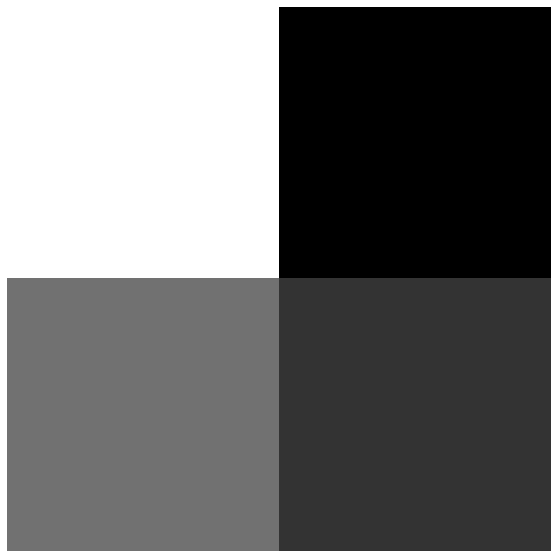

In [257]:
plt.figure(figsize=(10,10))
plt.imshow(Preprocessing.minmax_scaler(calc_featureimportance(data["x_train"],w)).reshape(2,2),cmap="gray",vmin=0)
plt.axis("off")
plt.show()